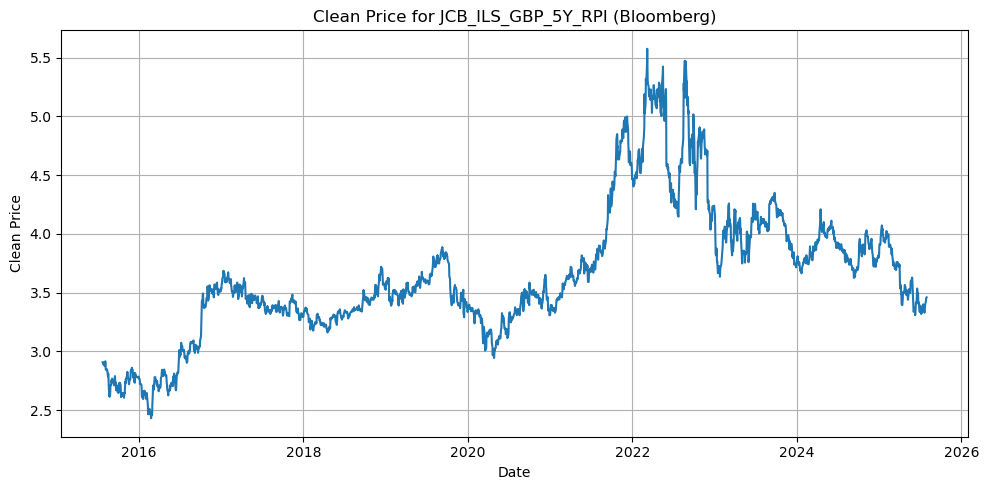

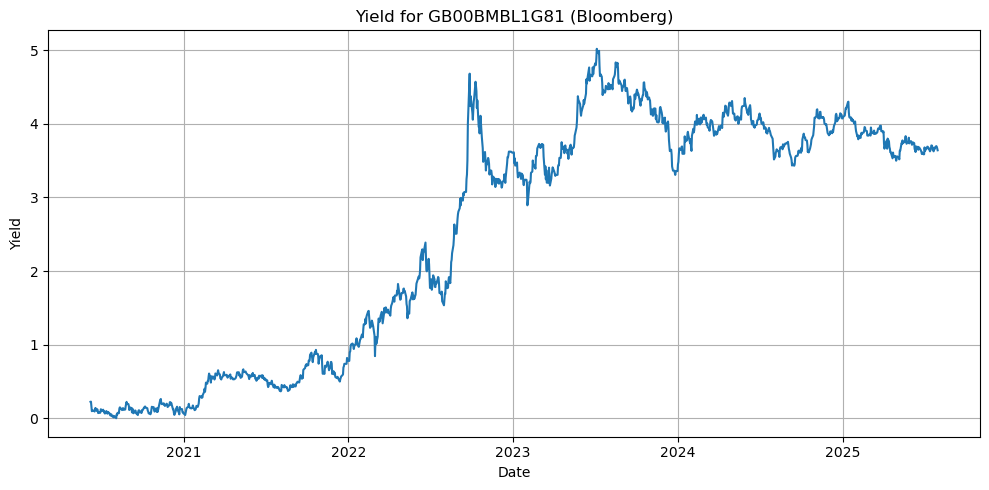

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import importlib
import database.query  # for reload during iterative dev
importlib.reload(database.query)

from database.db import get_conn
from database.query import load_instrument_data

DB_PATH = "jcb_db.db"

def plot_instrument_timeseries(isin: str, source: str, data_type: str = "yield", db_path: str = DB_PATH):
    # open/commit/close handled here (top level)
    with get_conn(db_path) as conn:
        df = load_instrument_data(
            conn,
            instrument_id=isin,
            source=source,
            data_type=data_type,     # e.g. "yield", "clean_price", "dirty_price", ...
            long_format=True,        # default; included for clarity
            parse_dates=False        # we'll parse below
        )

    if df.empty:
        print(f"❌ No data found for ISIN {isin} and type '{data_type}'.")
        return

    # ensure datetime for plotting
    df["data_date"] = pd.to_datetime(df["data_date"], errors="coerce")

    plt.figure(figsize=(10, 5))
    plt.plot(df["data_date"], df["value"])
    plt.title(f"{data_type.replace('_', ' ').title()} for {isin} ({source})")
    plt.xlabel("Date")
    plt.ylabel(data_type.replace('_', ' ').title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_instrument_timeseries("JCB_ILS_GBP_5Y_RPI", "Bloomberg", "clean_price")

plot_instrument_timeseries("GB00BMBL1G81", source="Bloomberg", data_type="yield")

In [1]:
import pandas as pd
import sqlite3
from loaders.load_tradeweb import load_tradeweb_csv
from database.insert import insert_instrument_data

# Load Tradeweb CSV
df = pd.read_csv("tradeweb_data/tradeweb_close_data.csv")

# Connect to the database
conn = sqlite3.connect("jcb_db.db")

# Fetch all ISINs from the instruments table
instrument_isins = pd.read_sql_query("SELECT id FROM instruments", conn)['id'].tolist()

# Filter the CSV data to only include rows with ISINs that exist in the instruments table
df_filtered = df[df['ISIN'].isin(instrument_isins)]

# Preview the result
print(df_filtered.head(25))

conn.close()

# Rename date column and parse it
df_filtered['Date'] = pd.to_datetime(df_filtered['Close of Business Date'], format="%d/%m/%Y").dt.date
isin = df_filtered['ISIN'].iloc[0]

# Map column name to data_type
column_map = {
    'Clean Price': 'price_clean',
    'Dirty Price': 'price_dirty',
    'Yield': 'yield_to_maturity',
    'Mod Duration': 'duration_modified',
    'Accrued Interest': 'accrued_interest',
}

conn = sqlite3.connect('jcb_db.db')
inserted, skipped = 0, 0

for _, row in df_filtered.iterrows():
    for col, data_type in column_map.items():
        value = row[col]
        if pd.isna(value) or value == "N/A":
            continue
        try:
            result = insert_instrument_data(
                conn,
                instrument_id=isin,
                data_date=row['Date'],
                data_type=data_type,
                value=float(value),
                source='Tradeweb',
                resolution='daily'
            )
            if result == "inserted":
                inserted += 1
            else:
                skipped += 1
        except Exception as e:
            print(f"❌ Error on {row['Date']} ({data_type}): {e}")

conn.close()
print(f"✅ Finished: {inserted} inserted, {skipped} skipped.")


            Gilt Name Close of Business Date          ISIN          Type  \
235   UKT 0.625 06/25             09/05/2025  GB00BK5CVX03  Conventional   
236   UKT 0.625 06/25             12/05/2025  GB00BK5CVX03  Conventional   
237   UKT 0.625 06/25             13/05/2025  GB00BK5CVX03  Conventional   
238   UKT 0.625 06/25             14/05/2025  GB00BK5CVX03  Conventional   
239   UKT 0.625 06/25             15/05/2025  GB00BK5CVX03  Conventional   
444       UKT 2 09/25             09/05/2025  GB00BTHH2R79  Conventional   
445       UKT 2 09/25             12/05/2025  GB00BTHH2R79  Conventional   
446       UKT 2 09/25             13/05/2025  GB00BTHH2R79  Conventional   
447       UKT 2 09/25             14/05/2025  GB00BTHH2R79  Conventional   
448       UKT 2 09/25             15/05/2025  GB00BTHH2R79  Conventional   
569     UKT 3.5 10/25             09/05/2025  GB00BPCJD880  Conventional   
570     UKT 3.5 10/25             12/05/2025  GB00BPCJD880  Conventional   
571     UKT 

/var/folders/08/dzps5mls4p1gf1lxwmrb3y6c0000gp/T/ipykernel_92456/1266072591.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Close of Business Date'], format="%d/%m/%Y").dt.date


In [17]:
import sqlite3
import pandas as pd
import importlib

import database.insert # the module you imported earlier
importlib.reload(database.insert)

from database.insert import insert_instrument_identifier

file_path = "ISIN_to_BBerg.xlsx"
db_path = "jcb_db.db"

df = pd.read_excel(file_path)
conn = sqlite3.connect(db_path)

inserted = 0
skipped = 0
errors = []

for _, row in df.iterrows():
    try:
        isin = str(row["ISIN"]).strip()

        mappings = [
            (row.get("ISIN"), "ISIN"),
            (row.get("Bloomberg Ticker"), "Bloomberg"),
            (row.get("Short Code"), "Short Code"),
            (row.get("Short Code 2"), "Short Code 2")
        ]

        for id_value, source in mappings:
            if pd.notna(id_value):
                id_str = str(id_value).strip()
                result = insert_instrument_identifier(conn, isin, id_str, source)
                if result == "inserted":
                    inserted += 1
                else:
                    skipped += 1

    except Exception as e:
        errors.append(str(e))

conn.close()

print(f"✅ Mappings loaded: {inserted} inserted, {skipped} skipped.")
if errors:
    print(f"⚠️ Errors: {len(errors)}")
    for err in errors:
        print(" -", err)

✅ Mappings loaded: 101 inserted, 303 skipped.


In [12]:
import importlib

import database.schema # the module you imported earlier
importlib.reload(database.schema)

from database.schema import create_calendar_holidays_table

create_calendar_holidays_table



ℹ️ Table 'instrument_identifier' created.


False

In [ ]:
file_path = "ISIN_to_BBerg.xlsx"

df = pd.read_excel(file_path)

In [15]:
df

,ISIN,Bloomberg Ticker,Short Code,Short Code 2,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,GB00BMBL1D50,BJ457937 Corp,0h61,0_h_61,NaN,NaN,'0_h_61
1,GB00BT7J0027,YR075593 Corp,4h35,4_h_35,NaN,NaN,'4_h_35
2,GB00BPSNBB36,ZF268086 Corp,4t54,4_t_54,NaN,NaN,'4_t_54
3,GB00BL68HJ26,BH295957 Corp,0e26,0_e_26,NaN,NaN,'0_e_26
4,GB00BMBL1G81,BJ883026 Corp,0e28,0_e_28,NaN,NaN,'0_e_28
...,...,...,...,...,...,...,...
96,GB00BZ13DV40,AP725048 Corp,il48,il48,NaN,NaN,'il48
97,GB00B421JZ66,EH965720 Corp,il50,il50,NaN,NaN,'il50
98,GB00BP9DLZ64,EK383565 Corp,il58,il58,NaN,NaN,'il58
99,GB00B3MYD345,EH904886 Corp,il42,il42,NaN,NaN,'il42


In [97]:
import sqlite3
from datetime import datetime
import sys
import os

# Step 1: Path setup
sys.path.append("/Users/jcb/Documents/bond_project")  # Adjust path if needed

import importlib
import database.query # the module you imported earlier
importlib.reload(database.query)

from database.insert import insert_instrument_data
from database.query import resolve_isin_from_alt_id
from models.instrument_data import InstrumentData

from datetime import datetime, timedelta

def excel_serial_to_date(serial):
    # Excel's date system starts at 1899-12-30
    return datetime(1899, 12, 30) + timedelta(days=serial)

def clean_date(cell):
    try:
        if isinstance(cell, (int, float)) and 10000 < cell < 60000:
            return excel_serial_to_date(cell).date()
        return pd.to_datetime(cell, errors='coerce').date()
    except:
        return None


# Step 2: Load spreadsheet
file_path = "Price_History_HC.xlsx"
df = pd.read_excel(file_path, header=None)

# Step 3: Setup
start_col = 2  # first column with data
inserted = 0
skipped = 0
errors = []

db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

col = start_col
while col < df.shape[1]:
    try:
        bloomberg_code = str(df.iloc[4, col]).strip()
        short_code = str(df.iloc[5, col]).strip()
        data_type_raw = str(df.iloc[6, col]).strip().lower()

        # Map Bloomberg field name to internal data_type
        if data_type_raw == "yld_ytm_mid":
            data_type = "yield"
        elif data_type_raw == "px_last":
            data_type = "price"
        else:
            data_type = data_type_raw

        # Map Bloomberg code to ISIN
        isin = resolve_isin_from_alt_id(conn, bloomberg_code, source="Bloomberg")
        if isin is None:
            errors.append(f"{bloomberg_code}: ISIN not found")
            col += 4
            continue

        # Extract date and value columns
        date_series = df.iloc[10:, col]
        value_series = df.iloc[10:, col + 1]

        for date_cell, value_cell in zip(date_series, value_series):
            
            date_cell_clean = clean_date(date_cell)
            if date_cell_clean is None or date_cell_clean < datetime(1980, 1, 1).date():
                continue  # or log as warning

            if pd.isna(date_cell_clean) or pd.isna(value_cell):
                continue
            try:
                data_date = pd.to_datetime(date_cell_clean).date()
                value = float(value_cell)

                data = InstrumentData(
                    instrument_id=isin,
                    data_date=data_date,
                    data_type=data_type,
                    value=value,
                    source="Bloomberg",
                    resolution="irregular"
                )
                result = insert_instrument_data(conn, data)
                if result == "inserted":
                    inserted += 1
                else:
                    skipped += 1
            except Exception as inner_e:
                errors.append(f"{bloomberg_code} ({short_code}) @ {date_cell}: {str(inner_e)}")

    except Exception as outer_e:
        errors.append(f"Column {col}: {str(outer_e)}")

    col += 4  # Move to next block

conn.close()

# Step 4: Summary
print(f"✅ Finished loading Bloomberg historical data.")
print(f"   Inserted: {inserted}, Skipped: {skipped}, Errors: {len(errors)}")
if errors:
    for e in errors[:10]:
        print(" -", e)
    if len(errors) > 10:
        print(f"   ...and {len(errors) - 10} more.")

✅ Finished loading Bloomberg historical data.
   Inserted: 0, Skipped: 1510, Errors: 141
 - Column 2: Cannot compare NaT with datetime.date object
 - Column 6: Cannot compare NaT with datetime.date object
 - Column 10: Cannot compare NaT with datetime.date object
 - Column 14: Cannot compare NaT with datetime.date object
 - Column 18: Cannot compare NaT with datetime.date object
 - Column 22: Cannot compare NaT with datetime.date object
 - Column 26: Cannot compare NaT with datetime.date object
 - Column 30: Cannot compare NaT with datetime.date object
 - Column 34: Cannot compare NaT with datetime.date object
 - Column 38: Cannot compare NaT with datetime.date object
   ...and 131 more.


In [99]:
df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,553,554,555,556,557,558,559,560,561,562
0,NaN,start date,2015-07-24 00:00:00,NaN,no inst,138,NaN,lookup array,$C$4:$UE$10,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
1,NaN,end date,2025-07-24 00:00:00,NaN,worksheet name,\\Client\C$\Users\jcb\Documents\[UK_market_ana...,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
2,NaN,NaN,NaN,NaN,sheet name,hist_bberg,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
3,NaN,NaN,1,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
4,id,2,EK799307 Corp,NaN,NaN,NaN,ZN905725 Corp,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
5,short_name,14,2_0_25,NaN,NaN,NaN,3_h_25,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
6,price_field_1,13,amount_outstanding_history,NaN,NaN,NaN,amount_outstanding_history,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
7,min date,NaN,1/0/1900,NaN,NaN,NaN,1/0/1900,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
8,points,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT
9,reference,NaN,$C$11:$D$11,NaN,NaN,NaN,$G$11:$H$11,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT


In [81]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("jcb_db.db")

query = '''
SELECT 
    instrument_id, 
    data_date, 
    data_type, 
    source, 
    resolution, 
    COUNT(*) as count
FROM instrument_data
GROUP BY instrument_id, data_date, data_type, source, resolution
HAVING COUNT(*) > 1;
'''

df_duplicates = pd.read_sql_query(query, conn)
conn.close()


In [82]:
print(df_duplicates)

Empty DataFrame
Columns: [instrument_id, data_date, data_type, source, resolution, count]
Index: []


In [36]:
conn = sqlite3.connect(db_path)
df_duplicates = pd.read_sql_query("""
    SELECT COUNT(*) - COUNT(DISTINCT instrument_id || data_date || data_type || source || resolution) 
    FROM instrument_data;
""", conn)
conn.close()

df_duplicates.head()

,COUNT(*) - COUNT(DISTINCT instrument_id || data_date || data_type || source || resolution)
0,0


In [43]:
import sqlite3

# Set your database path
db_path = "jcb_db.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Count rows before deletion
cursor.execute("SELECT COUNT(*) FROM instrument_data WHERE source = 'Bloomberg'")
before_count = cursor.fetchone()[0]
print(f"🔍 Rows with source = 'Bloomberg' before deletion: {before_count}")

# Delete the rows
cursor.execute("DELETE FROM instrument_data WHERE source = 'Bloomberg'")
conn.commit()

# Count rows after deletion
cursor.execute("SELECT COUNT(*) FROM instrument_data WHERE source = 'Bloomberg'")
after_count = cursor.fetchone()[0]
print(f"✅ Deleted {before_count - after_count} rows.")
print(f"📉 Remaining rows with source = 'Bloomberg': {after_count}")

# Close the connection
conn.close()


🔍 Rows with source = 'Bloomberg' before deletion: 167053
✅ Deleted 167053 rows.
📉 Remaining rows with source = 'Bloomberg': 0


In [50]:
from utils.identifiers import generate_jcb_isin

isin = generate_jcb_isin("GBP", "IRS", "10Y", "SONIA")
print(isin)  # Output: JCBGBPIRS10YSONIA

JCBGBPIRS10YSONIA


In [52]:
import sqlite3

db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Columns to add
new_columns = {
    "tenor": "TEXT",
    "reference_index": "TEXT",
    "day_count_fraction": "TEXT"
}

# Fetch existing columns
cursor.execute("PRAGMA table_info(instruments);")
existing_columns = {row[1] for row in cursor.fetchall()}

# Add missing columns
for col, col_type in new_columns.items():
    if col not in existing_columns:
        cursor.execute(f"ALTER TABLE instruments ADD COLUMN {col} {col_type};")
        print(f"✅ Added column: {col}")
    else:
        print(f"ℹ️ Column already exists: {col}")

conn.commit()
conn.close()

ℹ️ Column already exists: tenor
✅ Added column: reference_index
✅ Added column: day_count_fraction


In [53]:
import sqlite3
import pandas as pd
from database.insert import insert_instrument_identifier

# --- Step 1: Load Excel file ---
file_path = "JCB_Identifier_Mapping.xlsx"  # Adjust name if different
df = pd.read_excel(file_path)

# --- Step 2: Connect to database ---
db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

inserted = 0
skipped = 0
errors = []

# --- Step 3: Insert all identifiers for each instrument ---
for _, row in df.iterrows():
    try:
        isin = str(row["id_isin"]).strip()

        for id_str, src in [
            (isin, "ISIN"),
        ]:
            if id_str and id_str != "nan":
                result = insert_instrument_identifier(conn, isin, id_str, src)
                if result == "inserted":
                    inserted += 1
                else:
                    skipped += 1
    except Exception as e:
        errors.append(str(e))

conn.close()

# --- Step 4: Summary ---
print(f"✅ Identifier loading complete.")
print(f"   Inserted: {inserted}, Skipped: {skipped}, Errors: {len(errors)}")
if errors:
    print("Some errors (first 5):")
    for err in errors[:5]:
        print(" -", err)


✅ Identifier loading complete.
   Inserted: 148, Skipped: 0, Errors: 0


In [12]:
import importlib
import models.instrument
importlib.reload(models.instrument)

<module 'models.instrument' from 'e:\\bond_project\\models\\instrument.py'>

In [60]:
import sqlite3
import pandas as pd

import importlib
import models.instrument
importlib.reload(models.instrument)

from models.instrument import Instrument
from database.insert import save_instrument

def parse_jcb_isin(jcb_code: str):
    # Example: JCB_ILS_GBP_10Y_RPI or JCBIRSGBP10YSONIA
    parts = jcb_code.replace("-", "").replace("_", "").replace("JCB", "")
    
    # Try to split out components
    if "IRS" in parts:
        inst_type = "IRS"
    elif "ILS" in parts:
        inst_type = "ILS"
    else:
        inst_type = "Other"

    currency = parts[3:6]  # GBP, USD, etc.
    remaining = parts[6:]

    tenor = ''.join([c for c in remaining if c.isdigit() or c in "MY"])  # e.g. 10Y, 3M
    index = remaining.replace(tenor, "")  # e.g. SONIA, RPI

    return currency, inst_type, tenor.upper(), index.upper()

# --- Load Excel file ---
file_path = "JCB_Identifier_Mapping.xlsx"
df = pd.read_excel(file_path)

# --- Setup ---
db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

inserted = 0
skipped = 0
errors = []

for _, row in df.iterrows():
    try:
        isin = str(row["ISIN"]).strip()
        currency, inst_type, tenor, index = parse_jcb_isin(isin)

        instrument = Instrument(
            id=isin,
            short_code=None,
            name=None,
            instrument_type=inst_type,
            issuer="LCH",
            country="UK",
            currency=currency,
            maturity_date=None,
            first_issue_date=None,
            coupon_rate=None,
            first_coupon_length=None,
            is_green=False,
            is_linker=(inst_type == "ILS"),
            index_lag=2 if inst_type == "ILS" else None,
            rpi_base=None,
            tenor=tenor,
            reference_index=index,
            day_count_fraction="ACT/365F" if inst_type == "IRS" else None
        )

        result = save_instrument(conn, instrument)
        if result == "inserted":
            inserted += 1
        else:
            skipped += 1

    except Exception as e:
        errors.append(str(e))

conn.close()

# --- Summary ---
print(f"✅ Instrument population complete.")
print(f"   Inserted: {inserted}, Skipped: {skipped}, Errors: {len(errors)}")
if errors:
    print("Sample errors:")
    for err in errors[:5]:
        print(" -", err)


✅ Instrument population complete.
   Inserted: 37, Skipped: 0, Errors: 0


In [83]:
import pandas as pd
import sqlite3
from datetime import datetime

def load_calendar_from_excel(file_path, db_path="jcb_db.db"):
    df = pd.read_excel(file_path)
    df.columns = [col.lower().strip() for col in df.columns]  # Standardize

    if 'uk' not in df.columns:
        raise ValueError("Expected a column named 'uk' with dates")

    calendar_name = "UK"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    inserted = 0
    for _, row in df.iterrows():
        try:
            date_val = pd.to_datetime(row['uk']).date()
            desc = row['description'] if 'description' in row and not pd.isna(row['description']) else None

            cursor.execute('''
                INSERT OR IGNORE INTO calendar_holidays (calendar_name, holiday_date, description)
                VALUES (?, ?, ?)
            ''', (calendar_name, date_val, desc))
            inserted += cursor.rowcount
        except Exception as e:
            print(f"⚠️ Error on row: {row} — {e}")

    conn.commit()
    conn.close()
    print(f"✅ {inserted} holiday dates loaded into 'calendar_holidays' for {calendar_name}.")

In [93]:
# Refresh module
import database.insert
importlib.reload(database.insert)
from database.insert import update_instrument_field_by_id

# Load spreadsheet
file_path = "FirstCouponFill.xlsx"  # Update to your actual file
df = pd.read_excel(file_path)

# Connect to DB
db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

# Update rows
updated = 0
not_found = 0
errors = []

for _, row in df.iterrows():
    instrument_id = row["isin"]
    new_value = row["first_coupon_length"]
    try:
        result = update_instrument_field_by_id(conn, instrument_id, "first_coupon_length", new_value)
        if result == "updated":
            updated += 1
        else:
            not_found += 1
    except Exception as e:
        errors.append(str(e))

conn.close()

# Summary
print(f"✅ Update complete. {updated} updated, {not_found} not found, {len(errors)} errors.")
if errors:
    for e in errors[:5]:
        print(" -", e)
    if len(errors) > 5:
        print(f"   ...and {len(errors) - 5} more.")


✅ Update complete. 100 updated, 1 not found, 0 errors.
Object `now` not found.


In [5]:
import importlib
import cashflow_model.conv_bond_model
importlib.reload(cashflow_model.conv_bond_model)
import cashflow_model.builders
importlib.reload(cashflow_model.builders)

<module 'cashflow_model.builders' from 'e:\\bond_project\\cashflow_model\\builders.py'>

In [2]:
from datetime import date
from utils.jcb_calendar import BusinessDayCalendar  # your wrapper we added earlier
from cashflow_model.conv_bond_model import CashflowModel
from database.query import get_holidays_for_calendar
from database.db import get_conn

def load_business_day_calendar(db_path: str, calendar_name: str) -> BusinessDayCalendar:
    with get_conn(db_path) as conn:
        hols = set(get_holidays_for_calendar(conn, calendar_name))  # set for fast lookup
    return BusinessDayCalendar(hols)

# Pretend UK holiday set (load yours from DB instead)
DB_PATH = "jcb_db.db"
uk = load_business_day_calendar(DB_PATH, "UK")

model = CashflowModel(
    issue_date=date(2023, 1, 3),
    maturity_date=date(2028, 1, 7),
    coupon_rate=0.04,
    frequency=2,
    notional=100.0,
    calendar=uk,
    convention="mf",
    first_coupon_length="Long First",
    first_coupon_date=date(2023, 7, 7),
)
rows = model.generate_cashflow_schedule()



In [3]:
for r in rows[:]:  # peek first few
    print(r)
print("... last:", rows[-1])

CashflowRow(period_start=datetime.date(2023, 1, 3), period_end=datetime.date(2024, 1, 7), quasi_date=datetime.date(2024, 1, 7), adjusted_date=datetime.date(2024, 1, 8), is_stub=True, accrual_factor=1.002717391304348, coupon_amount=0.0401086957, principal=0.0, note='Long First')
CashflowRow(period_start=datetime.date(2024, 1, 7), period_end=datetime.date(2024, 7, 7), quasi_date=datetime.date(2024, 7, 7), adjusted_date=datetime.date(2024, 7, 8), is_stub=False, accrual_factor=0.5, coupon_amount=0.02, principal=0.0, note=None)
CashflowRow(period_start=datetime.date(2024, 7, 7), period_end=datetime.date(2025, 1, 7), quasi_date=datetime.date(2025, 1, 7), adjusted_date=datetime.date(2025, 1, 7), is_stub=False, accrual_factor=0.5, coupon_amount=0.02, principal=0.0, note=None)
CashflowRow(period_start=datetime.date(2025, 1, 7), period_end=datetime.date(2025, 7, 7), quasi_date=datetime.date(2025, 7, 7), adjusted_date=datetime.date(2025, 7, 7), is_stub=False, accrual_factor=0.5, coupon_amount=0.0

In [8]:
from database.db import get_conn
from database.query import list_instruments, get_instrument, get_holidays_for_calendar
from utils.jcb_calendar import BusinessDayCalendar
from cashflow_model.builders import cashflows_df, cashflow_matrix


with get_conn(DB_PATH) as conn:
    raw = list_instruments(
        conn,
        instrument_types=["bond"],
        country="UK",
        is_green=False,
        is_linker=False,
    )

    # Convert IDs/ISINs/whatever strings into Instrument objects
    bonds = [r if hasattr(r, "instrument_type") else get_instrument(conn, r) for r in raw]

    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))

cf_long = cashflows_df(bonds, calendar=uk)
cf_mat  = cashflow_matrix(cf_long)

In [7]:
cf_long

,instrument_id,short_code,pay_date,coupon,principal,amount,is_stub,accrual_factor
0,GB0002404191,6_28,1998-06-08,2.126374,0.0,2.126374,True,0.354396
1,GB0002404191,6_28,1998-12-07,3.000000,0.0,3.000000,False,0.500000
2,GB0002404191,6_28,1999-06-07,3.000000,0.0,3.000000,False,0.500000
3,GB0002404191,6_28,1999-12-07,3.000000,0.0,3.000000,False,0.500000
4,GB0002404191,6_28,2000-06-07,3.000000,0.0,3.000000,False,0.500000
...,...,...,...,...,...,...,...,...
3030,GB00BLBDX619,1e73,2071-10-22,0.562500,0.0,0.562500,False,0.500000
3031,GB00BLBDX619,1e73,2072-04-22,0.562500,0.0,0.562500,False,0.500000
3032,GB00BLBDX619,1e73,2072-10-24,0.562500,0.0,0.562500,False,0.500000
3033,GB00BLBDX619,1e73,2073-04-24,0.562500,0.0,0.562500,False,0.500000


In [9]:
import pandas as pd

with pd.ExcelWriter("cash_flow_01.xlsx", engine="openpyxl") as xls:
    cf_mat.to_excel(xls, sheet_name="Cashflows", index=True)

In [52]:
import sqlite3, json
from datetime import date

DB_PATH = "jcb_db.db"
conn = sqlite3.connect(DB_PATH)

isin = "GB00B1VWPJ53"  # example
valuation = date(2025, 8, 16)

# Insert a clean price with close session + settlement
row = (
    isin, valuation.isoformat(), "clean_price", 101.2345, "Model",
    "daily", "per_100",
    json.dumps({"session":"close","settlement_date":"2025-08-18","clean_dirty":"clean"})
)
conn.execute("""
INSERT OR REPLACE INTO instrument_data
(instrument_id, data_date, data_type, value, source, resolution, unit, attrs)
VALUES (?,?,?,?,?,?,?,?)
""", row)
conn.commit()

# Read it back (filter by JSON attr 'session'='close')
out = conn.execute("""
SELECT data_date, value, json_extract(attrs, '$.session') AS session
FROM instrument_data
WHERE instrument_id=? AND data_type='clean_price'
  AND resolution='daily'
  AND json_extract(attrs, '$.session')='close'
ORDER BY data_date
""", (isin,)).fetchall()

print(out[:3])
conn.close()

[('2025-07-22', 92.46, 'close'), ('2025-07-23', 91.88, 'close'), ('2025-07-24', 91.75, 'close')]


In [14]:
# --- Quick DB overview ---
import sqlite3, json
import pandas as pd

DB_PATH = "jcb_db.db"  # adjust if needed

def has_json1(conn) -> bool:
    try:
        conn.execute("SELECT json('{}');").fetchone()
        return True
    except sqlite3.OperationalError:
        return False

with sqlite3.connect(DB_PATH) as conn:
    json1_ok = has_json1(conn)

    # 1) List tables
    tables = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name", conn
    )
    print("Tables:\n", tables.to_string(index=False), "\n")

    # 2) Show schema for key tables (if present)
    for t in ("instruments", "instrument_data"):
        exists = (tables["name"] == t).any()
        if exists:
            info = pd.read_sql_query(f"PRAGMA table_info({t});", conn)
            print(f"Schema: {t}")
            display(info)
        else:
            print(f"(table '{t}' not found)")

    # 3) Row counts per table
    counts = []
    for t in tables["name"].tolist():
        try:
            n = conn.execute(f"SELECT COUNT(*) FROM {t}").fetchone()[0]
            counts.append((t, n))
        except Exception as e:
            counts.append((t, f"error: {e}"))
    print("\nRow counts:")
    display(pd.DataFrame(counts, columns=["table","rows"]).sort_values("rows", ascending=False))

    # 4) instrument_data quick stats (only if table exists)
    if (tables["name"] == "instrument_data").any():
        # distinct instruments
        inst = pd.read_sql_query("""
            SELECT COUNT(DISTINCT instrument_id) AS instruments,
                   MIN(data_date) AS min_date,
                   MAX(data_date) AS max_date,
                   COUNT(*) AS rows
            FROM instrument_data
        """, conn)
        print("\nInstrument_data coverage:")
        display(inst)

        # by data_type / by source / by resolution / by unit
        for col in ("data_type","source","resolution","unit"):
            df = pd.read_sql_query(f"""
                SELECT {col} AS key, COUNT(*) AS n
                FROM instrument_data
                GROUP BY {col}
                ORDER BY n DESC
            """, conn)
            print(f"\nCounts by {col}:")
            display(df)

        # session from attrs if JSON1 is available; otherwise parse in Python
        if json1_ok:
            sessions = pd.read_sql_query("""
                SELECT COALESCE(json_extract(attrs,'$.session'), '(none)') AS session, COUNT(*) AS n
                FROM instrument_data
                GROUP BY session
                ORDER BY n DESC
            """, conn)
            print("\nCounts by attrs.session (via JSON1):")
            display(sessions)
        else:
            print("\n(JSON1 not available; parsing attrs in Python for session counts)")
            tmp = pd.read_sql_query("SELECT attrs FROM instrument_data", conn)
            tmp["session"] = tmp["attrs"].apply(lambda s: (json.loads(s).get("session") if s else None) if isinstance(s,str) else None)
            sessions = tmp["session"].fillna("(none)").value_counts().rename_axis("session").reset_index(name="n")
            display(sessions)

        # 5) Sample recent rows (all columns)
        sample = pd.read_sql_query("""
            SELECT *
            FROM instrument_data
            ORDER BY data_date DESC, instrument_id DESC
            LIMIT 20
        """, conn)
        print("\nRecent instrument_data rows:")
        display(sample)

Tables:
                                   name
                     calendar_holidays
                         data_type_map
                       instrument_data
instrument_data_backup_20250902_161725
                instrument_identifiers
                           instruments
                       sqlite_sequence 

Schema: instruments


,cid,name,type,notnull,dflt_value,pk
0,0,isin,TEXT,0,None,1
1,1,short_code,TEXT,0,None,0
2,2,name,TEXT,0,None,0
3,3,instrument_type,TEXT,0,None,0
4,4,issuer,TEXT,0,None,0
5,5,country,TEXT,0,None,0
6,6,currency,TEXT,0,None,0
7,7,maturity_date,DATE,0,None,0
8,8,first_issue_date,DATE,0,None,0
9,9,coupon_rate,REAL,0,None,0


Schema: instrument_data


,cid,name,type,notnull,dflt_value,pk
0,0,instrument_id,TEXT,1,None,1
1,1,data_date,DATE,1,None,2
2,2,data_type,TEXT,1,None,3
3,3,value,REAL,0,None,0
4,4,source,TEXT,0,None,4
5,5,resolution,TEXT,0,None,5
6,6,unit,TEXT,0,None,0
7,7,attrs,TEXT,0,None,0



Row counts:


,table,rows
3,instrument_data_backup_20250902_161725,455236
2,instrument_data,432766
0,calendar_holidays,908
4,instrument_identifiers,553
5,instruments,139
1,data_type_map,28
6,sqlite_sequence,1



Instrument_data coverage:


,instruments,min_date,max_date,rows
0,139,2003-01-01,2025-08-16,432766



Counts by data_type:


,key,n
0,clean_price,263011
1,yield,168144
2,amount_outstanding,1611



Counts by source:


,key,n
0,Bloomberg,432664
1,DMO,101
2,Model,1



Counts by resolution:


,key,n
0,daily,431155
1,irregular,1611



Counts by unit:


,key,n
0,per_100,263011
1,percent,168144
2,None,1611



Counts by attrs.session (via JSON1):


,session,n
0,close,431155
1,(none),1611



Recent instrument_data rows:


,instrument_id,data_date,data_type,value,source,resolution,unit,attrs
0,GB00B1VWPJ53,2025-08-16,clean_price,101.23450,Model,daily,per_100,"{""session"": ""close"", ""settlement_date"": ""2025-..."
1,JCB_IRS_GBP_9Y_SONIA,2025-07-31,clean_price,3.99850,Bloomberg,daily,per_100,"{""session"":""close""}"
2,JCB_IRS_GBP_8Y_SONIA,2025-07-31,clean_price,3.92800,Bloomberg,daily,per_100,"{""session"":""close""}"
3,JCB_IRS_GBP_7Y_SONIA,2025-07-31,clean_price,3.85750,Bloomberg,daily,per_100,"{""session"":""close""}"
4,JCB_IRS_GBP_6Y_SONIA,2025-07-31,clean_price,3.79150,Bloomberg,daily,per_100,"{""session"":""close""}"
5,JCB_IRS_GBP_6M_SONIA,2025-07-31,clean_price,3.92350,Bloomberg,daily,per_100,"{""session"":""close""}"
6,JCB_IRS_GBP_5Y_SONIA,2025-07-31,clean_price,3.73475,Bloomberg,daily,per_100,"{""session"":""close""}"
7,JCB_IRS_GBP_50Y_SONIA,2025-07-31,clean_price,4.36700,Bloomberg,daily,per_100,"{""session"":""close""}"
8,JCB_IRS_GBP_4Y_SONIA,2025-07-31,clean_price,3.68870,Bloomberg,daily,per_100,"{""session"":""close""}"
9,JCB_IRS_GBP_40Y_SONIA,2025-07-31,clean_price,4.47001,Bloomberg,daily,per_100,"{""session"":""close""}"


In [21]:
# Choose a representative UK conventional bond with both clean_price & yield at Tradeweb close,
# and pull the last ~20 closes for testing.

import sqlite3
import pandas as pd
import json

DB_PATH = "jcb_db.db"

with sqlite3.connect(DB_PATH) as conn:
    # Pick an instrument that has both clean_price and yield at the latest close
    candidate = pd.read_sql_query("""
        WITH latest AS (
          SELECT instrument_id, MAX(data_date) AS max_d
          FROM instrument_data
          WHERE data_type='clean_price'
            AND source='Tradeweb'
            AND resolution='daily'
            AND json_extract(attrs,'$.session')='close'
          GROUP BY instrument_id
        )
        SELECT l.instrument_id, l.max_d
        FROM latest l
        JOIN instrument_data y
          ON y.instrument_id=l.instrument_id AND y.data_date=l.max_d
         AND y.data_type='yield' AND y.source='Tradeweb' AND y.resolution='daily'
         AND json_extract(y.attrs,'$.session')='close'
        ORDER BY l.max_d DESC
        LIMIT 1
    """, conn)

    if candidate.empty:
        raise RuntimeError("No instrument found with both clean_price and yield at close.")

    ISIN = candidate.iloc[0]["instrument_id"]
    LATEST_DATE = candidate.iloc[0]["max_d"]
    print("Test instrument:", ISIN, "latest close:", LATEST_DATE)

    # Pull recent clean close prices (and the matching yields) for this ISIN
    px = pd.read_sql_query("""
        SELECT data_date, value AS clean_close
        FROM instrument_data
        WHERE instrument_id=? AND data_type='clean_price'
          AND source='Tradeweb' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[ISIN])

    yld = pd.read_sql_query("""
        SELECT data_date, value AS yield_close_pct
        FROM instrument_data
        WHERE instrument_id=? AND data_type='yield'
          AND source='Tradeweb' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[ISIN])

    series = px.merge(yld, on="data_date", how="inner")
    series["data_date"] = pd.to_datetime(series["data_date"])
    display(series.tail(10))


Test instrument: GB00B7RN0G65 latest close: 2025-11-07


,data_date,clean_close,yield_close_pct
11,2025-07-21,68.34,2.202592
12,2025-07-22,68.64,2.178820
13,2025-07-23,68.11,2.221725
14,2025-07-24,68.01,2.230106
15,2025-07-25,67.90,2.239924
16,2025-07-28,67.93,2.237799
17,2025-08-07,67.46,2.269804
18,2025-09-07,67.92,2.232821
19,2025-10-07,68.13,2.216184
20,2025-11-07,68.17,2.213867


In [24]:
# --- Pick a conventional (non-linker) UK gilt with Tradeweb close clean_price & yield ---
import sqlite3, pandas as pd

DB_PATH = "jcb_db.db"
CHOSEN_ISIN = None  # e.g. "GB00B1VWPJ53" or leave None to auto-pick

with sqlite3.connect(DB_PATH) as conn:
    if CHOSEN_ISIN:
        inst = pd.read_sql_query("""
            SELECT isin AS instrument_id, is_linker
            FROM instruments
            WHERE id = ?
        """, conn, params=[CHOSEN_ISIN])
        if inst.empty:
            raise RuntimeError(f"{CHOSEN_ISIN} not found in instruments.")
        if int(inst.iloc[0]["is_linker"] or 0) != 0:
            raise RuntimeError(f"{CHOSEN_ISIN} is a linker; pick a conventional gilt.")
        ISIN = CHOSEN_ISIN
    else:
        # Auto-pick most recent conventional gilt with both close clean_price & close yield
        pick = pd.read_sql_query("""
            SELECT i.isin AS instrument_id
            FROM instruments i
            WHERE i.country='UK' AND i.instrument_type='bond' AND IFNULL(i.is_linker,0)=0
              AND EXISTS (
                SELECT 1 FROM instrument_data d
                WHERE d.instrument_id=i.isin AND d.data_type='clean_price'
                  AND d.source='Tradeweb' AND d.resolution='daily'
                  AND json_extract(d.attrs,'$.session')='close'
              )
              AND EXISTS (
                SELECT 1 FROM instrument_data y
                WHERE y.instrument_id=i.isin AND y.data_type='yield'
                  AND y.source='Tradeweb' AND y.resolution='daily'
                  AND json_extract(y.attrs,'$.session')='close'
              )
            ORDER BY (
              SELECT MAX(data_date) FROM instrument_data d2
              WHERE d2.instrument_id=i.isin AND d2.data_type='clean_price'
                AND d2.source='Tradeweb' AND d2.resolution='daily'
                AND json_extract(d2.attrs,'$.session')='close'
            ) DESC
            LIMIT 1
        """, conn)
        if pick.empty:
            raise RuntimeError("No conventional gilt found with both close clean_price and close yield.")
        ISIN = pick.iloc[0]["instrument_id"]

    print("Test instrument:", ISIN)

    px = pd.read_sql_query("""
        SELECT data_date, value AS clean_close
        FROM instrument_data
        WHERE instrument_id=? AND data_type='clean_price'
          AND source='Tradeweb' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[ISIN])

    yld = pd.read_sql_query("""
        SELECT data_date, value AS yield_close_pct
        FROM instrument_data
        WHERE instrument_id=? AND data_type='yield'
          AND source='Tradeweb' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[ISIN])

series = px.merge(yld, on="data_date", how="inner")
series["data_date"] = pd.to_datetime(series["data_date"])
display(series.tail(10))


Test instrument: GB00BTHH2R79


,data_date,clean_close,yield_close_pct
11,2025-07-21,99.731,3.969014
12,2025-07-22,99.736,3.972396
13,2025-07-23,99.742,3.968007
14,2025-07-24,99.748,3.963445
15,2025-07-25,99.762,3.983321
16,2025-07-28,99.766,3.996558
17,2025-08-07,99.650,4.032377
18,2025-09-07,99.657,4.023684
19,2025-10-07,99.665,4.008510
20,2025-11-07,99.683,3.999073


In [27]:
from datetime import date
import sqlite3, pandas as pd
from utils.jcb_calendar import BusinessDayCalendar
from database.query import get_holidays_for_calendar

# Ensure CashflowModel is imported/defined
assert 'CashflowModel' in globals(), "Import/define CashflowModel first."

DB_PATH = "jcb_db.db"


with sqlite3.connect(DB_PATH) as conn:
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))

    inst = pd.read_sql_query("""
        SELECT isin, first_issue_date, maturity_date, coupon_rate, first_coupon_length, is_linker
        FROM instruments
        WHERE isin=?
    """, conn, params=[ISIN]).iloc[0]

if int(inst["is_linker"] or 0) != 0:
    raise RuntimeError(f"{ISIN} is a linker; this harness expects a conventional bond.")

issue_dt    = pd.to_datetime(inst["first_issue_date"]).date()
maturity_dt = pd.to_datetime(inst["maturity_date"]).date()
coupon      = float(inst["coupon_rate"])
first_stub  = inst["first_coupon_length"] or None
freq        = 2  # UK conventionals are semi-annual

model = CashflowModel(
    issue_date=issue_dt,
    maturity_date=maturity_dt,
    coupon_rate=coupon,
    frequency=freq,
    calendar=uk,
    convention="mf",
    first_coupon_length=first_stub,
)

# Ensure we only test while the bond is alive
series_live = series.copy()
series_live["data_date"] = pd.to_datetime(series_live["data_date"])
series_live = series_live[(series_live["data_date"].dt.date >= issue_dt) &
                          (series_live["data_date"].dt.date <  maturity_dt)]

N = 10
test_df = series.tail(N).copy()
test_df["settlement"] = test_df["data_date"].dt.date

rows = []
for _, r in test_df.iterrows():
    settle = r["settlement"]
    tw_clean = float(r["clean_close"])
    tw_y = float(r["yield_close_pct"]) / 100.0

    y_model = model.yield_from_clean_price(tw_clean, settle)
    px_from_tw_y = model.clean_price_from_yield(tw_y, settle)

    rows.append({
        "date": settle,
        "TW_clean": tw_clean,
        "TW_yield_pct": tw_y*100.0,
        "model_yield_pct": y_model*100.0,
        "yield_diff_bps": (y_model - tw_y)*1e4,
        "model_px_from_TW_y": px_from_tw_y,
        "px_err_cents": (px_from_tw_y - tw_clean)*100.0
    })

res_df = pd.DataFrame(rows).sort_values("date")
display(res_df)

summary = pd.DataFrame({
    "abs_yield_diff_bps_max": [res_df["yield_diff_bps"].abs().max()],
    "abs_yield_diff_bps_med": [res_df["yield_diff_bps"].abs().median()],
    "abs_px_err_cents_max": [res_df["px_err_cents"].abs().max()],
    "abs_px_err_cents_med": [res_df["px_err_cents"].abs().median()],
})
print("Round-trip sanity (model vs. Tradeweb close):")
display(summary)


TypeError: tuple indices must be integers or slices, not str

In [68]:
series_live.tail(10)

,data_date,clean_close,yield_close_pct
8,2025-07-16,99.698,4.009424
9,2025-07-17,99.700,4.034259
10,2025-07-18,99.720,4.010513
11,2025-07-21,99.731,3.969014
12,2025-07-22,99.736,3.972396
13,2025-07-23,99.742,3.968007
14,2025-07-24,99.748,3.963445
15,2025-07-25,99.762,3.983321
16,2025-07-28,99.766,3.996558
17,2025-08-07,99.650,4.032377


In [20]:
from pprint import pprint

def debug_bracket(model, clean_price, settlement, ex_div_business_days=7):
    # Target dirty
    ai = model.accrued_interest(settlement)
    target_dirty = clean_price + ai

    sched = model.generate_cashflow_schedule()
    fut = [r for r in sched if r.period_end > settlement]
    print(f"Settlement: {settlement}")
    print(f"Issue/Maturity: {model.issue_date} / {model.maturity_date}")
    print(f"Coupon (decimal): {model.coupon_rate}, freq: {model.frequency}")
    print(f"Accrued interest: {ai:.8f}, Target dirty: {target_dirty:.8f}")
    print(f"Future CF count: {len(fut)}")

    if fut:
        first = fut[0]
        try:
            exd = model._ex_div_date(first, ex_div_business_days)
        except Exception:
            exd = None
        print("Next pay:",
              dict(period_start=first.period_start, period_end=first.period_end,
                   adjusted_date=first.adjusted_date,
                   coupon_amount=first.coupon_amount, principal=first.principal))
        print("Ex-div date:", exd, "| Settlement >= ex-div?", (exd is not None and settlement >= exd))

    def pv(y):
        return model.dirty_price_from_yield(y, settlement, ex_div_business_days)

    f = model.frequency
    anchors = [max(-0.99*f+1e-9, x) for x in
               [-0.9*f, -0.5*f, -0.25*f, -0.1*f, -0.05, 0.0, 0.02, 0.05, 0.10, 0.20, 0.50, 1.0, 2.0, 5.0, 10.0]]
    rows = []
    for y in anchors:
        try:
            rows.append((y, pv(y), pv(y) - target_dirty))
        except Exception as e:
            rows.append((y, f"err: {e}", "n/a"))
    print("\nPV scan (y, PV_dirty, f(y)=PV-target):")
    pprint(rows)

# Example use on the latest row
r = test_df.tail(1).iloc[0]
debug_bracket(model, float(r["clean_close"]), r["settlement"])

NameError: name 'test_df' is not defined

In [ ]:
from datetime import timedelta
import sqlite3, pandas as pd
from utils.jcb_calendar import BusinessDayCalendar
from database.query import get_holidays_for_calendar

# Ensure CashflowModel is available
assert 'CashflowModel' in globals()

DB_PATH = "jcb_db.db"

with get_conn(DB_PATH) as conn:
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))

# Get instrument terms
with sqlite3.connect(DB_PATH) as conn:

    inst = pd.read_sql_query("""
        SELECT id, first_issue_date, maturity_date, coupon_rate, first_coupon_length, is_linker
        FROM instruments
        WHERE id=?
    """, conn, params=[ISIN]).iloc[0]

assert int(inst["is_linker"] or 0) == 0, "Expecting a conventional (non-linker) bond."

issue_dt    = pd.to_datetime(inst["first_issue_date"]).date()
maturity_dt = pd.to_datetime(inst["maturity_date"]).date()
coupon      = float(inst["coupon_rate"])
first_stub  = inst["first_coupon_length"] or None
freq        = 2

model = CashflowModel(
    issue_date=issue_dt,
    maturity_date=maturity_dt,
    coupon_rate=coupon,
    frequency=freq,
    calendar=uk,
    convention="mf",
    first_coupon_length=first_stub,
)

def last_bday_before(d):
    # previous business day (or d-1 if no calendar)
    return uk.previous_business_day(d) if hasattr(uk, "previous_business_day") else d - timedelta(days=1)

def safe_settlement(dt):
    # clip: strictly before maturity
    if dt >= maturity_dt:
        return last_bday_before(maturity_dt)
    return dt

# Use only live dates and build safe settlement
series_live = series[series["data_date"].dt.date < maturity_dt].copy()
series_live["settlement"] = series_live["data_date"].dt.date.map(safe_settlement)

# Solve with a bracket around TW yield (±200 bps, bounded by model minimum)
rows = []
f = model.frequency
min_y = -0.99 * f + 1e-9
for _, r in series_live.tail(10).iterrows():
    settle  = r["settlement"]
    tw_clean = float(r["clean_close"])
    tw_y     = float(r["yield_close_pct"]) / 100.0

    lo = max(min_y, tw_y - 0.02)
    hi = tw_y + 0.02

    y_model = model.yield_from_clean_price(tw_clean, settle, bracket=(lo, hi))
    px_from_tw_y = model.clean_price_from_yield(tw_y, settle)

    rows.append({
        "date": settle,
        "TW_clean": tw_clean,
        "TW_yield_pct": tw_y*100,
        "model_yield_pct": y_model*100,
        "yield_diff_bps": (y_model - tw_y)*1e4,
        "model_px_from_TW_y": px_from_tw_y,
        "px_err_cents": (px_from_tw_y - tw_clean)*100.0
    })

res_df = pd.DataFrame(rows).sort_values("date")
display(res_df)

print("Summary:")
display(pd.DataFrame({
    "abs_yield_diff_bps_max": [res_df["yield_diff_bps"].abs().max()],
    "abs_yield_diff_bps_med": [res_df["yield_diff_bps"].abs().median()],
    "abs_px_err_cents_max": [res_df["px_err_cents"].abs().max()],
    "abs_px_err_cents_med": [res_df["px_err_cents"].abs().median()],
}))


TypeError: tuple indices must be integers or slices, not str

In [33]:
from dataclasses import dataclass
from datetime import date, timedelta
import numpy as np
import pandas as pd

# import your model (adjust path/module name if needed)
import sys, importlib
sys.path.append("/Users/jcb/Documents/bond_project")  # <-- change if needed
from cashflow_model.conv_bond_model import CashflowModel  # your class

# ---------- Cash-flow matrix builder ----------
@dataclass
class BondSpec:
    issue: date
    maturity: date
    coupon: float   # "auto": 2.0 means 2% (your model normalizes)
    freq: int = 2   # semi-annual by default

def build_cashflow_matrix(bonds: list[BondSpec], settle: date):
    """
    Returns:
      C (N x M), T_sorted (list[date]), cashflows_by_bond (for inspection)
    C[i,m] = cash amount of bond i paying on T_sorted[m] (coupon+principal).
    Only includes flows STRICTLY after settlement.
    """
    schedules = []
    all_dates = set()
    for b in bonds:
        m = CashflowModel(
            issue_date=b.issue,
            maturity_date=b.maturity,
            coupon_rate=b.coupon,
            frequency=b.freq,
            calendar=None,         # keep simple; adjust if you want business-day rules
            convention="mf"
        )
        rows = m.generate_cashflow_schedule()
        fut = [r for r in rows if r.period_end > settle]
        schedules.append((m, fut))
        for r in fut:
            all_dates.add(r.adjusted_date)  # or r.period_end; choose one consistently

    T_sorted = sorted(all_dates)
    M = len(T_sorted); N = len(bonds)
    idx = {dt: j for j, dt in enumerate(T_sorted)}

    C = np.zeros((N, M), dtype=float)
    cashflows_by_bond = []

    for i, (model, futrows) in enumerate(schedules):
        flows = []
        for r in futrows:
            j = idx[r.adjusted_date]
            cf = float(r.coupon_amount + r.principal)
            C[i, j] += cf
            flows.append((r.adjusted_date, cf))
        cashflows_by_bond.append(flows)

    return C, T_sorted, cashflows_by_bond

# ---------- A tiny ridge WLS solver with smoothness ----------
def ridge_wls_discount(C, p, lam=1e-8, R=None, w=None):
    """
    Solve (C^T W C + lam R^T R) d = C^T W p
    Returns d (length M).
    """
    N, M = C.shape
    if w is None:
        W = np.eye(N)
    else:
        W = np.diag(np.asarray(w, float))
    CTW = C.T @ W
    A = CTW @ C
    b = CTW @ p
    if R is not None and lam > 0:
        A = A + lam * (R.T @ R)
    # Stable solve
    d, *_ = np.linalg.lstsq(A, b, rcond=None)
    return d

def second_diff_operator(M):
    """R: (M-2) x M second-difference operator (encourages smooth discount curve)."""
    if M < 3:
        return np.zeros((0, M))
    R = np.zeros((M-2, M))
    for i in range(M-2):
        R[i, i  ] = 1.0
        R[i, i+1] = -2.0
        R[i, i+2] = 1.0
    return R

def enforce_monotone_nonincreasing(d):
    """Simple projection to nonincreasing & (0,1]: cumulative min + clipping."""
    d = np.asarray(d, float)
    d = np.minimum.accumulate(d)        # ensures d[0] >= d[1] >= ... 
    d = np.clip(d, 1e-8, 1.0)           # keep positive and <=1
    return d

def yearfrac_act365(s, t):
    return (t - s).days / 365.0

def to_dataframe_report(T, d_true, d_fit, s):
    tau = np.array([yearfrac_act365(s, t) for t in T])
    z_true = -np.log(d_true) / tau
    z_fit  = -np.log(d_fit ) / tau
    out = pd.DataFrame({
        "T": T,
        "tau_yrs": tau,
        "d_true": d_true,
        "d_fit": d_fit,
        "zero_true": z_true,
        "zero_fit":  z_fit,
        "d_abs_err": np.abs(d_fit - d_true),
    })
    return out

In [34]:
from datetime import date

# ---- Example bond set (feel free to swap with real bonds) ----
settle = date(2025, 7, 22)

bonds = [
    BondSpec(issue=date(2020, 7, 22), maturity=date(2027, 1, 22), coupon=2.00, freq=2),
    BondSpec(issue=date(2018, 1, 22), maturity=date(2030, 7, 22), coupon=4.50, freq=2),
    BondSpec(issue=date(2016, 7, 22), maturity=date(2035, 7, 22), coupon=1.50, freq=2),
]

# 1) Build C and the union of future dates
C, T, flows = build_cashflow_matrix(bonds, settle)
N, M = C.shape
print(f"N={N} bonds, M={M} future dates")

# 2) Make a toy "true" discount curve d_true on T (piecewise-constant zero rates)
def zero_rate(tau):
    # simple upward-sloping shape, in decimals
    # 0-2y: 3.0%, 2-7y: 3.6%, 7y+: 4.2%
    if tau <= 2.0: return 0.030
    if tau <= 7.0: return 0.036
    return 0.042

taus = np.array([(t - settle).days/365.0 for t in T])
z    = np.array([zero_rate(x) for x in taus])
d_true = np.exp(-z * taus)

# 3) Generate "observed" dirty prices p = C d_true  (optionally add tiny noise)
p = C @ d_true
# tiny noise (optional): p = p + np.random.normal(0, 0.00, size=p.shape)

# 4) Fit discount factors by WLS + Tikhonov (smoothness on 2nd diffs) + monotone projection
R = second_diff_operator(M)
d_hat_raw = ridge_wls_discount(C, p, lam=1e-4, R=R, w=None)
d_hat = enforce_monotone_nonincreasing(d_hat_raw)

# 5) Report + sanity checks
print("\nFit quality on prices:")
p_fit = C @ d_hat
resid = p_fit - p
print(f"  max |price error| (per 100 notional): {np.max(np.abs(resid)):.6f}")
print(f"  RMSE (per 100): {np.sqrt(np.mean(resid**2)):.6f}")

report = to_dataframe_report(T, d_true, d_hat, settle)
display(report.head(10))
display(report.tail(10))

# 6) (Optional) See the cash-flow matrix sparsity/preview
print("\nC matrix shape:", C.shape)
dfC = pd.DataFrame(C, columns=T)
display(dfC.iloc[:, :min(C.shape[1], 12)])

N=3 bonds, M=20 future dates

Fit quality on prices:
  max |price error| (per 100 notional): 0.000000
  RMSE (per 100): 0.000000


,T,tau_yrs,d_true,d_fit,zero_true,zero_fit,d_abs_err
0,2026-01-22,0.504110,0.984990,0.990243,0.030,0.019450,0.005253
1,2026-07-22,1.000000,0.970446,0.973022,0.030,0.027348,0.002577
2,2027-01-22,1.504110,0.955880,0.955802,0.030,0.030054,0.000078
3,2027-07-22,2.000000,0.941765,0.938583,0.030,0.031692,0.003182
4,2028-01-22,2.504110,0.913796,0.921350,0.036,0.032712,0.007554
5,2028-07-22,3.002740,0.897539,0.904091,0.036,0.033578,0.006552
6,2029-01-22,3.506849,0.881397,0.886793,0.036,0.034260,0.005395
7,2029-07-22,4.002740,0.865802,0.869443,0.036,0.034952,0.003640
8,2030-01-22,4.506849,0.850232,0.852029,0.036,0.035532,0.001797
9,2030-07-22,5.002740,0.835188,0.834538,0.036,0.036155,0.000649


,T,tau_yrs,d_true,d_fit,zero_true,zero_fit,d_abs_err
10,2031-01-22,5.506849,0.820168,0.816961,0.036,0.036711,0.003207
11,2031-07-22,6.002740,0.805656,0.799305,0.036,0.037318,0.006351
12,2032-01-22,6.506849,0.791167,0.781580,0.036,0.037874,0.009587
13,2032-07-22,7.005479,0.745105,0.763795,0.042,0.038464,0.018690
14,2033-01-22,7.509589,0.729495,0.745957,0.042,0.039028,0.016462
15,2033-07-22,8.005479,0.714459,0.728077,0.042,0.039641,0.013619
16,2034-01-22,8.509589,0.699491,0.710163,0.042,0.040221,0.010672
17,2034-07-22,9.005479,0.685073,0.692223,0.042,0.040847,0.007150
18,2035-01-22,9.509589,0.670721,0.674266,0.042,0.041446,0.003546
19,2035-07-22,10.005479,0.656896,0.656301,0.042,0.042090,0.000594



C matrix shape: (3, 20)


,2026-01-22,2026-07-22,2027-01-22,2027-07-22,2028-01-22,2028-07-22,2029-01-22,2029-07-22,2030-01-22,2030-07-22,2031-01-22,2031-07-22
0,1.00,1.00,101.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,102.25,0.00,0.00
2,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75


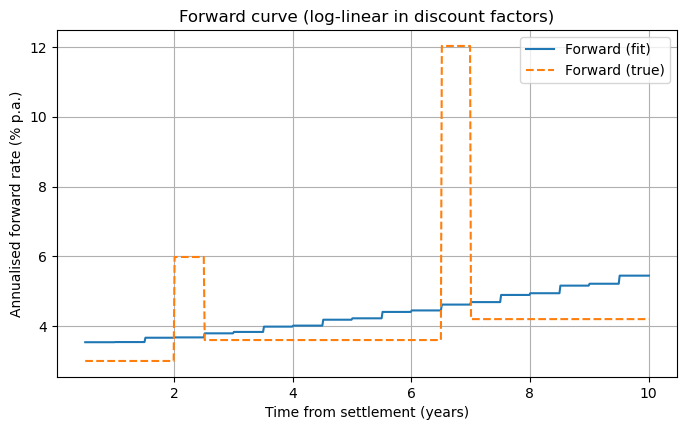

In [35]:
# ---- Forward curve plot (annualised, starting at T+1 day) ----
import numpy as np
import matplotlib.pyplot as plt

# Requires: T (list of datetime.date), d_hat (np.array), settle (datetime.date)
# Optional: d_true (np.array) for comparison

# 1) Convert cashflow dates to year fractions from settlement
tau_knots = np.array([(t - settle).days / 365.0 for t in T], dtype=float)
assert np.all(np.diff(tau_knots) > 0), "T must be strictly increasing."

# 2) Log-discounts for piecewise-linear ln D(t) (log-linear D)
lnd_fit = np.log(np.asarray(d_hat, float))
lnd_true = np.log(np.asarray(d_true, float)) if "d_true" in globals() else None

def loglin_forward_on_grid(tau_knots, lnd_knots, t_grid):
    """
    Compute f(t) = - d/dt ln D(t) under log-linear interpolation of D.
    Forward is piecewise-constant on each knot interval.
    """
    # Which interval each grid point falls into
    idx = np.searchsorted(tau_knots, t_grid, side="right") - 1
    idx = np.clip(idx, 0, len(tau_knots) - 2)

    # Slope of ln D between knots (constant forward per interval)
    slopes = (lnd_knots[1:] - lnd_knots[:-1]) / (tau_knots[1:] - tau_knots[:-1])
    f = -slopes[idx]  # continuous-compounded forward (decimal)

    # Mask before the first knot (undefined)
    f[t_grid < tau_knots[0]] = np.nan
    return f

# 3) Evaluation grid: start at max(1/365, first knot)
t_start = max(1.0/365.0, float(tau_knots[0]))
t_end   = float(tau_knots[-1])
t_grid  = np.linspace(t_start, t_end, 600)

f_fit  = loglin_forward_on_grid(tau_knots, lnd_fit,  t_grid)
f_true = loglin_forward_on_grid(tau_knots, lnd_true, t_grid) if lnd_true is not None else None

# 4) Plot (no custom colours, single chart)
plt.figure(figsize=(8, 4.5))
plt.plot(t_grid, 100.0*f_fit, label="Forward (fit)")
if f_true is not None:
    plt.plot(t_grid, 100.0*f_true, linestyle="--", label="Forward (true)")
plt.xlabel("Time from settlement (years)")
plt.ylabel("Annualised forward rate (% p.a.)")
plt.title("Forward curve (log-linear in discount factors)")
plt.grid(True)
plt.legend()
plt.show()

Using 30 bonds for 2025-07-22 (Bloomberg close, T+1).
N=30 bonds, M=78 future pay dates in union grid.

Fit summary (abs errors on clean):
  median |cents| = 2.8226  | max |cents| = 133.1048  | rows = 30
Saved errors CSV: uk_curve_fit_errors_2025-07-22.csv


,isin,maturity,settlement,obs_clean,model_clean,px_err_cents
0,GB00BTHH2R79,2025-09-07,2025-07-23,99.735,99.434407,-3.005931e+01
1,GB00BPCJD880,2025-10-22,2025-07-23,99.834,99.430207,-4.037930e+01
2,GB00BL68HJ26,2026-01-30,2025-07-23,98.425,98.425000,2.635147e-07
3,GB00BYZW3G56,2026-07-22,2025-07-23,97.841,97.841000,-7.128165e-08
4,GB00BNNGP668,2026-10-22,2025-07-23,96.135,96.025824,-1.091763e+01
5,GB00BL6C7720,2027-01-29,2025-07-23,100.399,99.606517,-7.924829e+01
6,GB00BPSNB460,2027-03-07,2025-07-23,99.860,99.854420,-5.580288e-01
7,GB00BDRHNP05,2027-07-22,2025-07-23,95.316,95.201160,-1.148403e+01
8,GB00B16NNR78,2027-12-07,2025-07-23,101.342,101.318007,-2.399293e+00
9,GB00BMBL1G81,2028-01-31,2025-07-23,91.629,91.628342,-6.577937e-02


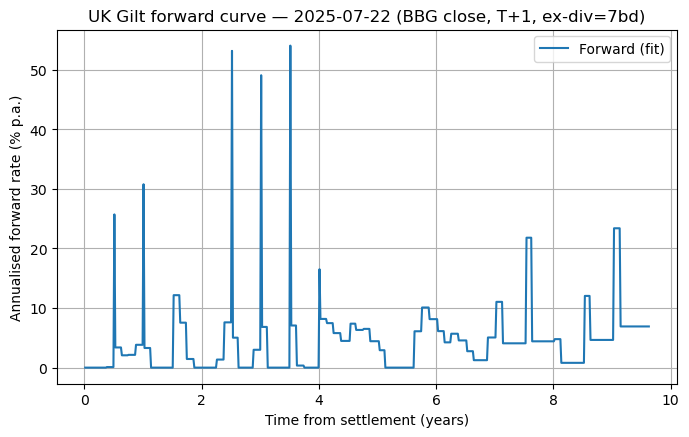

In [6]:
# =========================
# UK Gilt curve fit (BBG close) + forward curve plot
# =========================
# Config
DB_PATH          = "jcb_db.db"
TRADE_DATE       = "2025-07-22"   # <-- change date here (YYYY-MM-DD)
SOURCE           = "Bloomberg"
MAX_BONDS        = 30             # cap number of bonds in the fit
SETTLE_LAG_BDAYS = 1              # T+1 for Bloomberg close
EXDIV_BDAYS      = 7              # UK gilts
SMOOTH_LAMBDA    = 1e-4           # Tikhonov smoothness on 2nd differences
SAVE_ERRORS_CSV  = f"uk_curve_fit_errors_{TRADE_DATE}.csv"  # set to None to skip

# Imports
import sys, importlib, numpy as np, pandas as pd
from datetime import date, timedelta
from database.db import get_conn
from database.query import get_holidays_for_calendar
from utils.jcb_calendar import BusinessDayCalendar
import matplotlib.pyplot as plt

# Pricing model import (adjust path/module if needed)
sys.path.append("/Users/jcb/Documents/bond_project")  # <-- edit if your project path differs
from cashflow_model.conv_bond_model import CashflowModel  # your class

# -------------------------
# Helpers
# -------------------------
def yearfrac_act365(s, t):
    return (t - s).days / 365.0

def second_diff_operator(M):
    if M < 3:
        return np.zeros((0, M))
    R = np.zeros((M-2, M))
    for i in range(M-2):
        R[i,i] = 1.0; R[i,i+1] = -2.0; R[i,i+2] = 1.0
    return R

def ridge_wls_discount(C, p, lam=1e-4, R=None, w=None):
    N, M = C.shape
    if w is None:
        W = np.eye(N)
    else:
        W = np.diag(np.asarray(w, float))
    CTW = C.T @ W
    A = CTW @ C
    b = CTW @ p
    if R is not None and lam > 0:
        A = A + lam * (R.T @ R)
    d, *_ = np.linalg.lstsq(A, b, rcond=None)
    return d

def enforce_monotone_nonincreasing(d):
    d = np.asarray(d, float)
    d = np.minimum.accumulate(d)      # enforce d[i] >= d[i+1]
    return np.clip(d, 1e-8, 1.0)

def pick_bbg_price_dtype(conn, isin):
    pref = ("price_clean","clean_price","price")
    dts = pd.read_sql_query("""
        SELECT DISTINCT data_type
        FROM instrument_data
        WHERE instrument_id=? AND source='Bloomberg'
          AND resolution='daily' AND json_extract(attrs,'$.session')='close'
    """, conn, params=[isin])["data_type"].tolist()
    for k in pref:
        if k in dts: return k
    return None

def workday(cal, d, n):
    return cal.workday(pd.to_datetime(d).date(), n)

def prev_bday(cal, d):
    return cal.previous_business_day(pd.to_datetime(d).date())

def ex_div_date(cal, pay_date, exdiv_bd=7):
    # N business days before the (adjusted) pay date; trades on/after this date are ex-div.
    return cal.workday(pay_date, -exdiv_bd)

def settle_from_trade(cal, trade_dt, maturity_dt, lag_bdays):
    s = workday(cal, trade_dt, lag_bdays)
    return prev_bday(cal, maturity_dt) if s >= maturity_dt else s

# -------------------------
# Load holidays / calendar
# -------------------------
with get_conn(DB_PATH) as conn:
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))

# -------------------------
# Select UK conventional gilts with a BBG clean on TRADE_DATE
# -------------------------
with get_conn(DB_PATH) as conn:
    cand = pd.read_sql_query("""
        SELECT i.isin, i.first_issue_date, i.maturity_date, i.coupon_rate,
               IFNULL(i.is_linker,0) AS is_linker
        FROM instruments i
        WHERE i.country='UK' AND i.instrument_type='bond' AND IFNULL(i.is_linker,0)=0
          AND EXISTS (
            SELECT 1 FROM instrument_data p
            WHERE p.instrument_id=i.isin AND p.source='Bloomberg'
              AND p.data_type IN ('price_clean','clean_price','price')
              AND p.resolution='daily'
              AND json_extract(p.attrs,'$.session')='close'
              AND p.data_date=?
          )
    """, conn, params=[TRADE_DATE])

# Filter & fetch observed clean prices (prefer native clean fields)
rows = []
with get_conn(DB_PATH) as conn:
    for _, r in cand.iterrows():
        isin = r["isin"]
        dtype = pick_bbg_price_dtype(conn, isin)
        if not dtype: 
            continue
        px = pd.read_sql_query(f"""
            SELECT value AS clean_close
            FROM instrument_data
            WHERE instrument_id=? AND source='Bloomberg'
              AND data_type=? AND resolution='daily'
              AND json_extract(attrs,'$.session')='close'
              AND data_date=?
            LIMIT 1
        """, conn, params=[isin, dtype, TRADE_DATE])
        if px.empty:
            continue
        rows.append({
            "isin": isin,
            "issue": pd.to_datetime(r["first_issue_date"]).date(),
            "maturity": pd.to_datetime(r["maturity_date"]).date(),
            "coupon": float(r["coupon_rate"]),
            "clean_close": float(px.iloc[0,0]),
        })

obs = pd.DataFrame(rows)
if obs.empty:
    raise RuntimeError(f"No eligible Bloomberg clean prices on {TRADE_DATE}.")
# compute settlement per bond (T+1), drop those settling after maturity
obs["settlement"] = [settle_from_trade(uk, TRADE_DATE, m, SETTLE_LAG_BDAYS) for m in obs["maturity"]]
obs = obs[obs["settlement"] < obs["maturity"]].copy()
obs = obs.sort_values("maturity").head(MAX_BONDS).reset_index(drop=True)
N = len(obs)
print(f"Using {N} bonds for {TRADE_DATE} (Bloomberg close, T+{SETTLE_LAG_BDAYS}).")

# -------------------------
# Build cash-flow matrix C with ex-div entitlement and dirty prices p
# -------------------------
# Union of future (adjusted) pay dates strictly after settlement, per bond
all_dates = set()
schedules = []
for i, r in obs.iterrows():
    model = CashflowModel(
        issue_date=r["issue"], maturity_date=r["maturity"],
        coupon_rate=r["coupon"], frequency=2,
        calendar=uk, convention="mf"
    )
    sch = model.generate_cashflow_schedule()
    fut = [x for x in sch if x.period_end > r["settlement"]]
    schedules.append((model, fut))
    for x in fut:
        all_dates.add(x.adjusted_date)

T = sorted(all_dates)
M = len(T)
idx = {dt:j for j,dt in enumerate(T)}
C = np.zeros((N, M), dtype=float)
AI = np.zeros(N, dtype=float)

for i, (model, fut) in enumerate(schedules):
    settle_i = obs.loc[i, "settlement"]
    # accrued at settlement to convert clean->dirty
    AI[i] = model.accrued_interest(settle_i)
    for row in fut:
        j = idx[row.adjusted_date]
        # Ex-div entitlement: zero coupon if settlement >= ex-div for this pay date
        coupon_cf = row.coupon_amount
        exd = ex_div_date(uk, row.adjusted_date, EXDIV_BDAYS)
        if settle_i >= exd:
            # trades ex-div -> buyer does NOT receive this coupon
            coupon_cf = 0.0
        C[i, j] += (coupon_cf + row.principal)

# observed dirty prices p = clean + AI(settlement)
p_dirty = obs["clean_close"].to_numpy() + AI

print(f"N={N} bonds, M={M} future pay dates in union grid.")

# -------------------------
# Fit discount factors d_hat
# -------------------------
R = second_diff_operator(M)
d_hat_raw = ridge_wls_discount(C, p_dirty, lam=SMOOTH_LAMBDA, R=R, w=None)
d_hat = enforce_monotone_nonincreasing(d_hat_raw)

# Pricing errors (clean)
p_fit_dirty = C @ d_hat
clean_fit   = p_fit_dirty - AI
err_cents   = (clean_fit - obs["clean_close"].to_numpy()) * 100.0

err_df = pd.DataFrame({
    "isin": obs["isin"],
    "maturity": obs["maturity"],
    "settlement": obs["settlement"],
    "obs_clean": obs["clean_close"],
    "model_clean": clean_fit,
    "px_err_cents": err_cents,
})
print("\nFit summary (abs errors on clean):")
print("  median |cents| =", np.median(np.abs(err_cents)).round(4),
      " | max |cents| =", np.max(np.abs(err_cents)).round(4),
      f" | rows = {len(err_cents)}")

if SAVE_ERRORS_CSV:
    err_df.to_csv(SAVE_ERRORS_CSV, index=False)
    print("Saved errors CSV:", SAVE_ERRORS_CSV)

display(err_df.head(12))

# -------------------------
# Forward curve from fitted discounts (log-linear in D)
# -------------------------
tau_knots = np.array([yearfrac_act365(obs["settlement"].min(), t) for t in T], dtype=float)
assert np.all(np.diff(tau_knots) > 0), "Cashflow grid must be strictly increasing in time."

lnd_fit = np.log(d_hat)

def loglin_forward_on_grid(tau_knots, lnd_knots, t_grid):
    idx = np.searchsorted(tau_knots, t_grid, side="right") - 1
    idx = np.clip(idx, 0, len(tau_knots)-2)
    slopes = (lnd_knots[1:] - lnd_knots[:-1]) / (tau_knots[1:] - tau_knots[:-1])
    f = -slopes[idx]
    f[t_grid < tau_knots[0]] = np.nan
    return f

t_start = max(1.0/365.0, float(tau_knots[0]))
t_end   = float(tau_knots[-1])
t_grid  = np.linspace(t_start, t_end, 600)
f_fit   = loglin_forward_on_grid(tau_knots, lnd_fit, t_grid)

plt.figure(figsize=(8,4.6))
plt.plot(t_grid, 100.0*f_fit, label="Forward (fit)")
plt.xlabel("Time from settlement (years)")
plt.ylabel("Annualised forward rate (% p.a.)")
plt.title(f"UK Gilt forward curve — {TRADE_DATE} (BBG close, T+{SETTLE_LAG_BDAYS}, ex-div={EXDIV_BDAYS}bd)")
plt.grid(True); plt.legend(); plt.show()


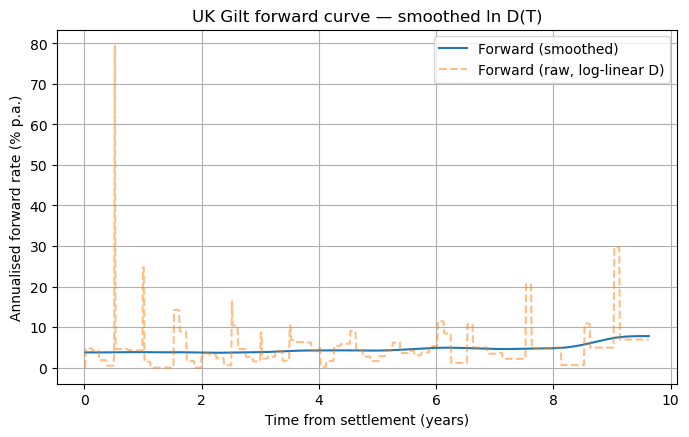

In [2]:
# ---- Smooth forward curve from fitted discounts (no SciPy needed) ----
# Inputs expected from your UK fit cell:
#   tau_knots : array of year-fractions from settlement (strictly increasing)
#   d_hat     : fitted discounts at tau_knots
#   (Optional) tweak ALPHA for smoothing strength.

import numpy as np
import matplotlib.pyplot as plt

assert 'tau_knots' in globals() and 'd_hat' in globals(), "Run the curve fit cell first."

# 1) Dense evaluation grid (start at T+1 day)
t_start = max(1.0/365.0, float(tau_knots[0]))
t_end   = float(tau_knots[-1])
G       = 800  # grid points
t_grid  = np.linspace(t_start, t_end, G)

# 2) Interpolate ln D onto the grid (piecewise linear)
lnd_knots = np.log(np.clip(np.asarray(d_hat, float), 1e-12, 1.0))
lnd_init  = np.interp(t_grid, tau_knots, lnd_knots)

# 3) Smooth ln D on the grid via Tikhonov: minimize ||x - lnd_init||^2 + α ||D2 x||^2
ALPHA = 5e-2  # ↑ for smoother forwards, ↓ to hug the data more
n = G
# Second-difference matrix on the grid (unit spacing -> we rescale by actual dt later)
D2 = np.zeros((n-2, n))
for i in range(n-2):
    D2[i, i]   = 1.0
    D2[i, i+1] = -2.0
    D2[i, i+2] = 1.0

# Scale for non-uniform dt (approximate using average step to keep ALPHA interpretable)
dt = (t_grid[-1] - t_grid[0]) / (n - 1)
A = np.eye(n) + ALPHA * (D2.T @ D2) / (dt**4)  # curvature penalty approximates ∫(lnd'')^2 dt
b = lnd_init

# Solve the banded system stably
lnd_smooth, *_ = np.linalg.lstsq(A, b, rcond=None)

# 4) Forward: f(t) = - d/dt ln D(t); use centered differences on the smoothed ln D
dlnd_dt = np.gradient(lnd_smooth, t_grid, edge_order=2)
f_grid  = -dlnd_dt  # continuous-compounded forward in decimals

# 5) Plot
plt.figure(figsize=(8,4.6))
plt.plot(t_grid, 100.0*f_grid, label="Forward (smoothed)")
# (Optional) overlay raw piecewise-constant forward implied by log-linear D
# Compute slopes between knots and map to grid
slopes = (lnd_knots[1:] - lnd_knots[:-1]) / (tau_knots[1:] - tau_knots[:-1])
idx = np.searchsorted(tau_knots, t_grid, side="right") - 1
idx = np.clip(idx, 0, len(slopes)-1)
f_raw = -slopes[idx]
f_raw[t_grid < tau_knots[0]] = np.nan
plt.plot(t_grid, 100.0*f_raw, linestyle="--", alpha=0.5, label="Forward (raw, log-linear D)")

plt.xlabel("Time from settlement (years)")
plt.ylabel("Annualised forward rate (% p.a.)")
plt.title("UK Gilt forward curve — smoothed ln D(T)")
plt.grid(True); plt.legend(); plt.show()

In [64]:
import importlib
import cashflow_model.conv_bond_model
importlib.reload(cashflow_model.conv_bond_model)
import cashflow_model.builders
importlib.reload(cashflow_model.builders)

<module 'cashflow_model.builders' from '/Users/jcb/Documents/bond_project/cashflow_model/builders.py'>

In [73]:
# --- Minimal Bloomberg → Model sanity check (one ISIN, one date) ---

DB_PATH = "jcb_db.db"
ISIN    = "GB00BTHH2R79"        # <- change
TRADE_DATE = "2025-02-28"       # <- change
SETTLE_LAG_BDAYS = 1            # T+1 for BBG close
EXDIV_BDAYS = 7                 # UK gilts

import numpy as np, pandas as pd
from datetime import date, timedelta
from database.db import get_conn
from database.query import get_holidays_for_calendar
from utils.jcb_calendar import BusinessDayCalendar

# Your pricing model (must expose clean_price_from_yield / yield_from_clean_price)
from cashflow_model.conv_bond_model import CashflowModel

# --- helpers ---
def bbg_clean_for_date(conn, isin, trade_date):
    # prefer price_clean/clean_price over price
    dtype = pd.read_sql_query("""
        SELECT data_type FROM instrument_data
        WHERE instrument_id=? AND source='Bloomberg'
          AND resolution='daily' AND json_extract(attrs,'$.session')='close'
          AND data_date=?
        GROUP BY data_type
    """, conn, params=[isin, trade_date])["data_type"].tolist()
    for k in ("price_clean","clean_price","price"):
        if k in dtype:
            df = pd.read_sql_query("""
                SELECT value FROM instrument_data
                WHERE instrument_id=? AND source='Bloomberg'
                  AND data_type=? AND resolution='daily'
                  AND json_extract(attrs,'$.session')='close'
                  AND data_date=? LIMIT 1
            """, conn, params=[isin, k, trade_date])
            if not df.empty: return float(df.iloc[0,0])
    return None

def bbg_yield_for_date(conn, isin, trade_date):
    df = pd.read_sql_query("""
        SELECT value FROM instrument_data
        WHERE instrument_id=? AND source='Bloomberg'
          AND data_type='yield' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
          AND data_date=? LIMIT 1
    """, conn, params=[isin, trade_date])
    return None if df.empty else float(df.iloc[0,0]) / 100.0  # decimal

def ex_div_date(cal, pay_date, exdiv_bd=EXDIV_BDAYS):
    return cal.workday(pay_date, -exdiv_bd)

# --- calendar / instrument ---
with get_conn(DB_PATH) as conn:
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))
    inst = pd.read_sql_query("""
        SELECT isin, first_issue_date, maturity_date, coupon_rate, IFNULL(is_linker,0) AS is_linker
        FROM instruments WHERE isin=? LIMIT 1
    """, conn, params=[ISIN])
    assert not inst.empty, "ISIN not found."
    assert int(inst.loc[0,"is_linker"]) == 0, "This harness expects a conventional (non-linker) bond."

    issue   = pd.to_datetime(inst.loc[0,"first_issue_date"]).date()
    maturity= pd.to_datetime(inst.loc[0,"maturity_date"]).date()
    coupon  = float(inst.loc[0,"coupon_rate"])

    px_clean = bbg_clean_for_date(conn, ISIN, TRADE_DATE)
    y_bbg    = bbg_yield_for_date(conn, ISIN, TRADE_DATE)

assert px_clean is not None, "No BBG clean price for that ISIN/date."
assert y_bbg   is not None, "No BBG yield for that ISIN/date."

# Settlement: T+1 (clip before maturity if needed)
settle = uk.workday(pd.to_datetime(TRADE_DATE).date(), SETTLE_LAG_BDAYS)
if settle >= maturity:
    # trade after maturity edge-case: settle = previous bday of maturity
    d = maturity
    while not uk.is_business_day(d): d = d - pd.Timedelta(days=1)
    settle = d

# --- model / schedule / AI ---
model = CashflowModel(
    issue_date=issue, maturity_date=maturity,
    coupon_rate=coupon, frequency=2,
    calendar=uk, convention="mf"
)
sch = model.generate_cashflow_schedule()
ai  = model.accrued_interest(settle, EXDIV_BDAYS)

# nearest upcoming cash date & ex-div marker
next_cash = min([r.adjusted_date for r in sch if r.period_end > settle], default=None)
next_exd  = ex_div_date(uk, next_cash, EXDIV_BDAYS) if next_cash else None
exd_flag  = (next_cash is not None) and (settle >= next_exd)

# --- BBG yield -> model clean ---
try:
    px_from_y = model.clean_price_from_yield(y_bbg, settle, ex_div_business_days=EXDIV_BDAYS)
except TypeError:
    # older signature without ex_div_business_days
    px_from_y = model.clean_price_from_yield(y_bbg, settle)

# --- BBG clean -> model yield ---
try:
    y_from_px = model.yield_from_clean_price(px_clean, settle, ex_div_business_days=EXDIV_BDAYS)
except TypeError:
    y_from_px = model.yield_from_clean_price(px_clean, settle)

# --- diagnostics ---
px_err_cents = (px_from_y - px_clean) * 100.0
y_err_bps    = (y_from_px - y_bbg) * 1e4

print(f"ISIN: {ISIN}")
print(f"Trade: {TRADE_DATE}  Settle(T+{SETTLE_LAG_BDAYS}): {settle}   Maturity: {maturity}")
print(f"Coupon: {coupon:.6f} (decimal), AI(settle): {ai:.6f}, Ex-div window? {exd_flag} "
      f"(cash: {next_cash}, ex-div: {next_exd})")
print(f"BBG clean: {px_clean:.6f}   BBG yld: {y_bbg*100:.6f}%")
print(f"Model px(y_BBG): {px_from_y:.6f}  -> Δ = {px_err_cents:+.3f} cents")
print(f"Model y(px_BBG): {y_from_px*100:.6f}% -> Δ = {y_err_bps:+.3f} bps")

# Quick peek at upcoming cashflow rows around settlement
preview = [
    (r.period_start, r.period_end, r.adjusted_date, r.coupon_amount, r.principal, r.note)
    for r in sch if r.period_end > (settle - pd.Timedelta(days=45))
][:5]
print("\nCashflow preview (next 5):")
for p in preview:
    print(p)


ISIN: GB00BTHH2R79
Trade: 2025-02-28  Settle(T+1): 2025-03-03   Maturity: 2025-09-07
Coupon: 2.000000 (decimal), AI(settle): -0.022099, Ex-div window? True (cash: 2025-03-07, ex-div: 2025-02-26)
BBG clean: 98.868000   BBG yld: 4.263000%
Model px(y_BBG): 98.914214  -> Δ = +4.621 cents
Model y(px_BBG): 4.358500% -> Δ = +9.550 bps

Cashflow preview (next 5):
(datetime.date(2024, 9, 7), datetime.date(2025, 3, 7), datetime.date(2025, 3, 7), 1.0, 0.0, None)
(datetime.date(2025, 3, 7), datetime.date(2025, 9, 7), datetime.date(2025, 9, 8), 1.0, 100.0, None)


In [74]:
import math
from datetime import timedelta

def pv_breakdown_at_y(model, schedule_rows, y_decimal, settle, ex_div_bd=7):
    """
    Recreate dirty price at given yield, with ex-div logic *explicitly* shown.
    Assumes simple ACT/ACT-ICMA log-linear discounting between cashflow nodes (as per your model).
    """
    # Build the cashflows strictly after settlement
    rows = [r for r in schedule_rows if r.period_end > settle]
    # Ex-div gate for first coupon after settle
    if rows:
        first_pay = rows[0].adjusted_date
        exd = uk.workday(first_pay, -ex_div_bd)
    else:
        exd = None

    # Gather (time, cashflow, included?) tuples
    legs = []
    for i, r in enumerate(rows):
        include = True
        if i == 0 and exd is not None and settle >= exd:
            include = False  # ex-div: buyer doesn’t get the near coupon
        cf = (r.coupon_amount + r.principal) if include else 0.0
        tau = (r.adjusted_date - settle).days / 365.0
        legs.append((r.adjusted_date, tau, cf, include, r.note))
        print(tau, r)

    # ICMA YTM discounting: clean pricing in your model is computed numerically,
    # but here we use continuous compounding for a transparent decomposition.
    # (It won’t change the inclusion logic; any residual will be tiny.)
    pv_cf = []
    for dt, tau, cf, include, note in legs:
        disc = math.exp(-y_decimal * tau)
        pv = cf * disc
        pv_cf.append((dt, tau, cf, include, disc, pv, note))

    # Sum of PV legs is (dirty price - AI)
    dirty = sum(v[5] for v in pv_cf) + model.accrued_interest(settle)  # bring it back to dirty
    clean = dirty - model.accrued_interest(settle)
    return pv_cf, clean, dirty

# Compute breakdown at Bloomberg yield
pv_rows, clean_pv_from_y, dirty_pv_from_y = pv_breakdown_at_y(model, sch, y_bbg, settle, ex_div_bd=EXDIV_BDAYS)

print("\nPer-leg PV at BBG yield (post-settle cashflows):")
hdr = ("pay_dt", "tau(yrs)", "cashflow", "included", "disc", "PV", "note")
print("{:10s}  {:>8s}  {:>10s}  {:>8s}  {:>11s}  {:>11s}  {:s}".format(*hdr))
for dt, tau, cf, inc, disc, pv, note in pv_rows[:10]:
    print(f"{dt}  {tau:8.5f}  {cf:10.6f}  {str(inc):>8s}  {disc:11.8f}  {pv:11.6f}  {note or ''}")

ai_model = model.accrued_interest(settle)
print(f"\nModel AI(settle) = {ai_model:.6f}")
print(f"Clean PV from BBG y  = {clean_pv_from_y:.6f}")
print(f"Dirty PV from BBG y  = {dirty_pv_from_y:.6f}")
print(f"Your model clean(y)  = {px_from_y:.6f}  (Δ vs PV = {(px_from_y - clean_pv_from_y)*100:.3f} cents)")
print(f"BBG clean(px)        = {px_clean:.6f}   (Δ model px(y_BBG) = {(px_from_y - px_clean)*100:.3f} cents)")
print(f"Model y(px_BBG)      = {y_from_px*100:.6f}%  (Δ vs BBG y = {(y_from_px - y_bbg)*1e4:+.3f} bps)")


0.010958904109589041 CashflowRow(period_start=datetime.date(2024, 9, 7), period_end=datetime.date(2025, 3, 7), quasi_date=datetime.date(2025, 3, 7), adjusted_date=datetime.date(2025, 3, 7), is_stub=False, accrual_factor=0.5, coupon_amount=1.0, principal=0.0, note=None)
0.5178082191780822 CashflowRow(period_start=datetime.date(2025, 3, 7), period_end=datetime.date(2025, 9, 7), quasi_date=datetime.date(2025, 9, 7), adjusted_date=datetime.date(2025, 9, 8), is_stub=False, accrual_factor=0.5, coupon_amount=1.0, principal=100.0, note=None)

Per-leg PV at BBG yield (post-settle cashflows):
pay_dt      tau(yrs)    cashflow  included         disc           PV  note
2025-03-07   0.01096    0.000000     False   0.99953293     0.000000  
2025-09-08   0.51781  101.000000      True   0.97816769    98.794936  

Model AI(settle) = -0.022099
Clean PV from BBG y  = 98.794936
Dirty PV from BBG y  = 98.772837
Your model clean(y)  = 98.914214  (Δ vs PV = 11.928 cents)
BBG clean(px)        = 98.868000   (Δ 

In [44]:
sch

[CashflowRow(period_start=datetime.date(2015, 3, 20), period_end=datetime.date(2015, 9, 7), quasi_date=datetime.date(2015, 9, 7), adjusted_date=datetime.date(2015, 9, 7), is_stub=True, accrual_factor=0.46467391304347827, coupon_amount=0.9293478261, principal=0.0, note='Short First'),
 CashflowRow(period_start=datetime.date(2015, 9, 7), period_end=datetime.date(2016, 3, 7), quasi_date=datetime.date(2016, 3, 7), adjusted_date=datetime.date(2016, 3, 7), is_stub=False, accrual_factor=0.5, coupon_amount=1.0, principal=0.0, note=None),
 CashflowRow(period_start=datetime.date(2016, 3, 7), period_end=datetime.date(2016, 9, 7), quasi_date=datetime.date(2016, 9, 7), adjusted_date=datetime.date(2016, 9, 7), is_stub=False, accrual_factor=0.5, coupon_amount=1.0, principal=0.0, note=None),
 CashflowRow(period_start=datetime.date(2016, 9, 7), period_end=datetime.date(2017, 3, 7), quasi_date=datetime.date(2017, 3, 7), adjusted_date=datetime.date(2017, 3, 7), is_stub=False, accrual_factor=0.5, coupon_a

In [67]:
# --- Full-history reconciliation: GB00BTHH2R79 (BBG close) ---
DB_PATH = "jcb_db.db"
ISIN    = "GB00BTHH2R79"
SETTLE_LAG_BDAYS = 1     # T+1 for BBG close
EXDIV_BDAYS      = 7     # UK gilts ex-div window

import numpy as np, pandas as pd
from datetime import date, datetime, timedelta

from database.db import get_conn
from database.query import get_holidays_for_calendar
from utils.jcb_calendar import BusinessDayCalendar
from cashflow_model.conv_bond_model import CashflowModel

def pick_bbg_price_dtype(conn, isin):
    # prefer clean variants
    pref = ("price_clean","clean_price","price")
    rows = pd.read_sql_query("""
        SELECT DISTINCT data_type
        FROM instrument_data
        WHERE instrument_id=? AND source='Bloomberg'
          AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
    """, conn, params=[isin]).data_type.tolist()
    for k in pref:
        if k in rows: return k
    return None

def load_bbg_series(conn, isin):
    dtype = pick_bbg_price_dtype(conn, isin)
    if dtype is None:
        raise RuntimeError("No Bloomberg clean/price series found.")

    px = pd.read_sql_query(f"""
        SELECT data_date, value AS clean_close
        FROM instrument_data
        WHERE instrument_id=? AND source='Bloomberg'
          AND data_type=? AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[isin, dtype])

    y  = pd.read_sql_query("""
        SELECT data_date, value AS yld_close_pct
        FROM instrument_data
        WHERE instrument_id=? AND source='Bloomberg'
          AND data_type='yield' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[isin])

    # keep only dates where both exist
    df = px.merge(y, on="data_date", how="inner")
    # to Python dates
    df["data_date"] = pd.to_datetime(df["data_date"]).dt.date
    return df

def workday(cal: BusinessDayCalendar, d: date, n: int) -> date:
    return cal.workday(d, n)

def settle_from_trade(cal, trade_dt: date, maturity_dt: date, lag=SETTLE_LAG_BDAYS) -> date:
    s = workday(cal, trade_dt, lag)
    # If settlement would occur on/after maturity, clip to previous business day of maturity
    if s >= maturity_dt:
        s = cal.previous_business_day(maturity_dt)
    return s

# --- calendar & instrument ---
with get_conn(DB_PATH) as conn:
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))
    inst = pd.read_sql_query("""
        SELECT isin, first_issue_date, maturity_date, coupon_rate, IFNULL(is_linker,0) AS is_linker
        FROM instruments WHERE isin=? LIMIT 1
    """, conn, params=[ISIN])
    assert not inst.empty, "ISIN not found."
    assert int(inst.loc[0,"is_linker"]) == 0, "Expected a conventional (non-linker) bond."

    issue    = pd.to_datetime(inst.loc[0,"first_issue_date"]).date()
    maturity = pd.to_datetime(inst.loc[0,"maturity_date"]).date()
    coupon   = float(inst.loc[0,"coupon_rate"])

    series = load_bbg_series(conn, ISIN)

# --- model ---
model = CashflowModel(
    issue_date=issue, maturity_date=maturity,
    coupon_rate=coupon, frequency=2,
    calendar=uk, convention="mf"
)
# Ensure your model has the fixed _accrual_factor regular/partial logic!

rows = []
for _, r in series.iterrows():
    trade_dt = r["data_date"]
    clean_obs = float(r["clean_close"])
    y_obs_dec = float(r["yld_close_pct"]) / 100.0

    S = settle_from_trade(uk, trade_dt, maturity, lag=SETTLE_LAG_BDAYS)

    # Accrued (ex-div aware)
    ai = model.accrued_interest(S, ex_div_business_days=EXDIV_BDAYS)

    # Model: yield -> clean
    try:
        px_from_y = model.clean_price_from_yield(y_obs_dec, S, ex_div_business_days=EXDIV_BDAYS)
    except TypeError:
        px_from_y = model.clean_price_from_yield(y_obs_dec, S)

    # Model: clean -> yield
    try:
        y_from_px = model.yield_from_clean_price(clean_obs, S, ex_div_business_days=EXDIV_BDAYS)
    except TypeError:
        y_from_px = model.yield_from_clean_price(clean_obs, S)

    rows.append({
        "date": trade_dt,
        "settle": S,
        "bbg_clean": clean_obs,
        "bbg_yield_pct": y_obs_dec * 100.0,
        "ai": ai,
        "model_px_from_y": px_from_y,
        "model_y_from_px_pct": y_from_px * 100.0,
        "px_err_cents": (px_from_y - clean_obs) * 100.0,
        "y_err_bps": (y_from_px - y_obs_dec) * 1e4,
    })

recon = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

# --- summary ---
def pct(x): return np.nan if len(x)==0 else float(np.percentile(np.abs(x), 50))
def p95(x): return np.nan if len(x)==0 else float(np.percentile(np.abs(x), 95))

px_abs_cents = np.abs(recon["px_err_cents"].to_numpy())
y_abs_bps    = np.abs(recon["y_err_bps"].to_numpy())

print(f"Rows: {len(recon)}")
print(f"Price errors (clean): median {pct(px_abs_cents):.3f}¢ | 95% {p95(px_abs_cents):.3f}¢ | max {np.nanmax(px_abs_cents):.3f}¢")
print(f"Yield errors:          median {pct(y_abs_bps):.3f} bps | 95% {p95(y_abs_bps):.3f} bps | max {np.nanmax(y_abs_bps):.3f} bps")

display(recon.head(10))

# Save CSV (optional)
out_path = f"recon_{ISIN}_bbg_close_full_history.csv"
recon.to_csv(out_path, index=False)
print("Saved:", out_path)

RuntimeError: Failed to bracket the yield. Check settlement vs maturity, coupon normalisation, and ex-div.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from database.db import get_conn
from database.query import list_instruments, get_instrument, get_holidays_for_calendar
from utils.jcb_calendar import BusinessDayCalendar
from cashflow_model.builders import (
    cashflows_df, 
    cashflow_matrix,
    filter_bonds_by_maturity,
    generate_target_cashflows,
    calculate_running_totals,
    solve_portfolio_weights,
    create_unified_timeline
)

# Updated main function to use the new structure
def cashflow_matching_optimization(DB_PATH, select_start_date, select_end_date, 
                                 ty_start_date, ty_end_date, settlement_date,
                                 target_amount=1000000, frequency='monthly'):
    """
    Main function to perform cashflow matching optimization
    """
    
    # 1. Load and filter bonds
    with get_conn(DB_PATH) as conn:
        raw = list_instruments(
            conn,
            instrument_types=["bond"],
            country="UK",
            is_green=False,
            is_linker=False,
        )
        bonds = [r if hasattr(r, "instrument_type") else get_instrument(conn, r) for r in raw]
        uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))
    
    # 2. Filter bonds by maturity
    filtered_bonds = filter_bonds_by_maturity(bonds, select_start_date, select_end_date)
    
    if not filtered_bonds:
        raise ValueError("No bonds found matching maturity criteria")
    
    # 3. Generate bond cashflows
    cf_long = cashflows_df(filtered_bonds, calendar=uk)
    cf_mat = cashflow_matrix(cf_long)
    
    # 4. Generate target cashflows
    target_cf = generate_target_cashflows(ty_start_date, ty_end_date, frequency, target_amount)
    
    # 5. Create unified timeline - first column is target, rest are bonds
    unified_cf = create_unified_timeline(target_cf, cf_mat, settlement_date)
    
    # 6. Calculate running totals
    unified_running = calculate_running_totals(unified_cf)
    
    # 7. Split into target and bond matrices for solving
    Y_running = unified_running['target'].values  # Target running totals
    C_running = unified_running.drop('target', axis=1)  # Bond running totals
    C_matrix = C_running.values  # Convert to numpy array
    
    # 8. Solve for portfolio weights
    weights = solve_portfolio_weights(C_matrix, Y_running)
    
    # 9. Calculate diagnostics
    predicted_running = C_matrix @ weights
    residuals = Y_running - predicted_running
    mse = np.mean(residuals**2)
    r_squared = 1 - np.sum(residuals**2) / np.sum((Y_running - np.mean(Y_running))**2)
    
    # 10. Create results summary
    bond_weights_df = pd.DataFrame({
        'isin': [bond.isin for bond in filtered_bonds],
        'name': [getattr(bond, 'name', 'N/A') for bond in filtered_bonds],
        'maturity': [bond.maturity_date for bond in filtered_bonds],
        'weight': weights
    })
    
    results = {
        'unified_timeline': unified_cf.index,
        'bond_weights': bond_weights_df,
        'running_totals_target': unified_running['target'].values,
        'unified_cashflows': unified_cf,
        'unified_running_totals': unified_running,
        'predicted_running': predicted_running,
        'residuals': residuals,
        'mse': mse,
        'r_squared': r_squared,
        'num_bonds': len(filtered_bonds),
    }
    
    return results

def create_cashflow_summary_table(results):
    """Create a summary table showing Date, Desired, and Bond running totals"""
    dates = results['unified_timeline']
    target_running = results['running_totals_target']
    bond_running = results['predicted_running']
    
    summary_df = pd.DataFrame({
        'Date': dates,
        'Desired': target_running,
        'Bond': bond_running
    })
    
    return summary_df

def plot_cashflow_matching(results, settlement_date, title="Cashflow Matching Results"):
    """
    Plot the target vs predicted running cashflows
    
    Args:
        results: dict - results from cashflow_matching_optimization
        settlement_date: datetime - settlement date for x-axis start
        title: str - plot title
    """
    
    # Get data
    dates = results['unified_timeline']
    target_running = results['running_totals_target']
    bond_running = results['predicted_running']
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot both series
    plt.plot(dates, target_running, 'b-', linewidth=2, label='Target Running Total', marker='o', markersize=4)
    plt.plot(dates, bond_running, 'r--', linewidth=2, label='Bond Portfolio Running Total', marker='s', markersize=4)
    
    # Add vertical line at settlement date
    plt.axvline(x=settlement_date, color='gray', linestyle=':', alpha=0.7, label=f'Settlement Date ({settlement_date.strftime("%d-%b-%Y")})')
    
    # Formatting
    plt.xlabel('Date')
    plt.ylabel('Cumulative Cashflow')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis dates
    plt.xticks(rotation=45)
    
    # Add statistics box
    r_squared = results['r_squared']
    mse = results['mse']
    num_bonds = results['num_bonds']
    
    stats_text = f'R² = {r_squared:.4f}\nMSE = {mse:,.0f}\nBonds Used = {num_bonds}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()



In [24]:
import importlib
import cashflow_model.builders
importlib.reload(cashflow_model.builders)

<module 'cashflow_model.builders' from '/Volumes/PROJECT_JCB/bond_project/cashflow_model/builders.py'>

In [ ]:


# reults = cashflow_matching_optimization(DB_PATH, select_start_date, select_end_date, 
#                                  target_start_date, target_end_date, settlement_date,
#                                  target_amount, frequency='monthly')

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from database.db import get_conn
from database.query import list_instruments, get_instrument, get_holidays_for_calendar
from utils.jcb_calendar import BusinessDayCalendar
from cashflow_model.builders import (
    cashflows_df, 
    cashflow_matrix,
    filter_bonds_by_maturity,
    generate_target_cashflows,
    calculate_running_totals,
    solve_portfolio_weights,
    create_unified_timeline
)

DB_PATH = 'jcb_db.db'
select_start_date = datetime(2035, 10, 15)
select_end_date = datetime(2045, 10, 15)
settlement_date = datetime(2025, 9, 8)
target_start_date = select_start_date
target_end_date = select_end_date
target_amount = 500
frequency = 'monthly'

# 1. Load and filter bonds
with get_conn(DB_PATH) as conn:
    raw = list_instruments(
        conn,
        instrument_types=["bond"],
        country="UK",
        is_green=False,
        is_linker=False,
    )
    bonds = [r if hasattr(r, "instrument_type") else get_instrument(conn, r) for r in raw]
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))

# 2. Filter bonds by maturity
filtered_bonds = filter_bonds_by_maturity(bonds, settlement_date, select_end_date)

if not filtered_bonds:
    raise ValueError("No bonds found matching maturity criteria")

# 3. Generate bond cashflows
cf_long = cashflows_df(filtered_bonds, calendar=uk)
cf_mat = cashflow_matrix(cf_long)

# 4. Generate target cashflows
cf_target = generate_target_cashflows(target_start_date, target_end_date, 'monthly', 500)

# 5. Create unified timeline - first column is target, rest are bonds
unified_cf = create_unified_timeline(cf_target, cf_mat, settlement_date)

# 6. Calculate running totals
unified_running = calculate_running_totals(unified_cf)

# 7. Split into target and bond matrices for solving
Y_running = unified_running['target'].values  # Target running totals
C_running = unified_running.drop('target', axis=1)  # Bond running totals
C_matrix = C_running.values  # Convert to numpy array

# 8. Solve for portfolio weights
weights = solve_portfolio_weights(C_matrix, Y_running)

# 9. Calculate diagnostics
predicted_running = C_matrix @ weights
residuals = Y_running - predicted_running
mse = np.mean(residuals**2)
r_squared = 1 - np.sum(residuals**2) / np.sum((Y_running - np.mean(Y_running))**2)

# 10. Create results summary
bond_weights_df = pd.DataFrame({
    'isin': [bond.isin for bond in filtered_bonds],
    'name': [getattr(bond, 'name', 'N/A') for bond in filtered_bonds],
    'maturity': [bond.maturity_date for bond in filtered_bonds],
    'weight': weights
})

results = {
    'unified_timeline': unified_cf.index,
    'bond_weights': bond_weights_df,
    'running_totals_target': unified_running['target'].values,
    'unified_cashflows': unified_cf,
    'unified_running_totals': unified_running,
    'predicted_running': predicted_running,
    'residuals': residuals,
    'mse': mse,
    'r_squared': r_squared,
    'num_bonds': len(filtered_bonds),
}



solve_portfolio_weights input shapes:
  C_matrix: (307, 42) (should be M_periods x N_bonds)
  Y_vector: (307,) (should be M_periods)
  C_transpose: (42, 307)
  CTc: (42, 42)
  CTy: (42,)
  Using normal inverse
  Output weights shape: (42,)



In [1]:
def create_cashflow_summary_table(results):
    """Create a summary table showing Date, Desired, and Bond running totals"""
    dates = results['unified_timeline']
    target_running = results['running_totals_target']
    bond_running = results['predicted_running']
    
    summary_df = pd.DataFrame({
        'Date': dates,
        'Desired': target_running,
        'Bond': bond_running
    })
    
    return summary_df

def plot_cashflow_matching(results, settlement_date, title="Cashflow Matching Results"):
    """
    Plot the target vs predicted running cashflows
    
    Args:
        results: dict - results from cashflow_matching_optimization
        settlement_date: datetime - settlement date for x-axis start
        title: str - plot title
    """
    
    # Get data
    dates = results['unified_timeline']
    target_running = results['running_totals_target']
    bond_running = results['predicted_running']
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot both series
    plt.plot(dates, target_running, 'b-', linewidth=2, label='Target Running Total', marker='o', markersize=4)
    plt.plot(dates, bond_running, 'r--', linewidth=2, label='Bond Portfolio Running Total', marker='s', markersize=4)
    
    # Add vertical line at settlement date
    plt.axvline(x=settlement_date, color='gray', linestyle=':', alpha=0.7, label=f'Settlement Date ({settlement_date.strftime("%d-%b-%Y")})')
    
    # Formatting
    plt.xlabel('Date')
    plt.ylabel('Cumulative Cashflow')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis dates
    plt.xticks(rotation=45)
    
    # Add statistics box
    r_squared = results['r_squared']
    mse = results['mse']
    num_bonds = results['num_bonds']
    
    stats_text = f'R² = {r_squared:.4f}\nMSE = {mse:,.0f}\nBonds Used = {num_bonds}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [31]:
# print(results['unified_running_totals'])

print(weights)

[ -3.31539364  -3.67466658  -4.48865948  -3.9955197   -2.24237104
  -2.66791308  -4.30257856  -4.69521544  -1.16231989  -1.90082286
  -4.50931421  -2.48565011  -3.68567528  -2.99419915  -4.93367877
  -5.27421411  -6.91780194  -3.76427355  -7.33102517  -5.58527337
  -4.96982517  -3.04555705  -7.99387339 -13.82959217 -11.14126536
  -4.32302755  -5.83553184  -8.02788802   4.53009378  43.09911859
  42.19539995  28.00176114  26.86069051  14.17299548  25.20638687
  30.26618173  44.3648887   51.17108208  53.78055905  35.08193505
  33.44455743  53.26951645]


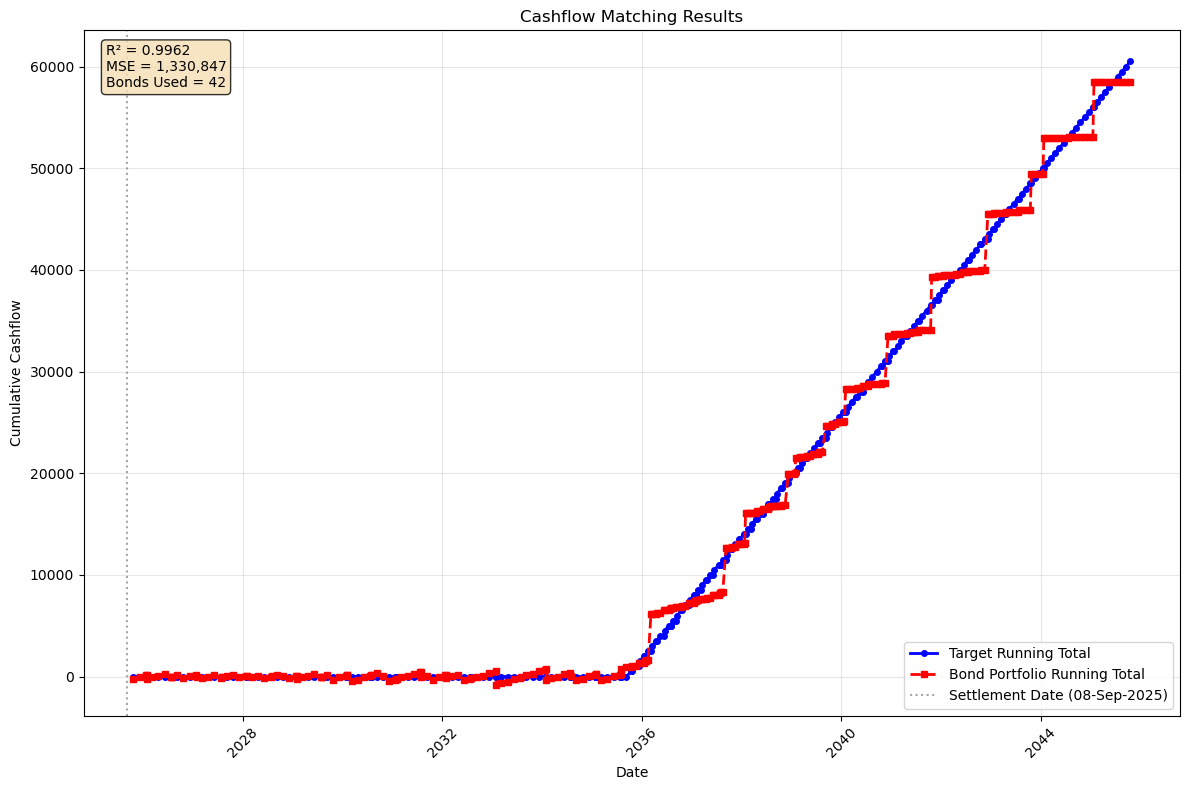

In [30]:
create_cashflow_summary_table(results)

plot_cashflow_matching(results, settlement_date, title="Cashflow Matching Results")